# CoCluster SC & Biomark
__Author__: Elisabeth F. Heuston

## Purpose

Single cell transcriptional and clustering analysis of LSK, CMP, MEP, and GMP data presented in Heuston et al., 2021  

raw data are available at

## Updates

### 2021.09.29  
This version keeps dCt comparisons  
This version tries to add LSK and MEP

### 2021.09.28  
Compared to 'archive2', this version uses a `seurat.object` subseted to probes in biomark assay before normalization.

## Workbook setup

## Load modules

In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter, ExcelFile
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import savefig
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import re
from icecream import ic

## User-defined functions


In [2]:
def generate_probe_statistics(df, sheetname, writer):
    stats_table=pd.DataFrame()
    stats_table['Failed Probe'] = df.sum(axis=1)==0
    stats_table['sum'] = df.sum(axis=1).round(2)
    stats_table['min Ct'] = df.min(axis=1).round(2)
    stats_table['max Ct'] = df.max(axis=1).round(2)
    stats_table['mean Ct'] = biomark_ctIndexed.mean(axis=1).round(2)
    stats_table['median Ct'] = df.median(axis=1).round(2)
    stats_table['Ct std'] = df.std(axis=1).round(2)
    stats_table.to_excel(writer, sheetname)

### apply_ct_limits

In [3]:
def apply_ct_limits(x, lowerlimit, upperlimit):
    if x < lowerlimit or x > upperlimit:
        return 0
    else:
        return x

### dCt

In [4]:
def dCt (plate, ref_list = ["Actb", "B2m", "Cd117"]):

    failed = []
    [failed.append(x) for x in plate if not plate.columns.str.contains(x).any()]
    
    # Test if table in correct format
    if bool(failed):
        print('None of', failed, 'found in columns')        
        
    refCt = plate[plate[ref_list] > 0].mean(axis = 1)
    plate = plate.subtract(refCt, axis = 0)
    return plate

### cell_filter

In [5]:
def cell_filter(plate, lowerlimit = 8, upperlimit = 40, min_passed_tests = 30, min_passed_references = 2, avg_ct_thresh = None, transpose_plate = True):
    
    # Read plate
    plate.columns = ['Well ID', 'Probe', 'Ct']
    plate['Ct'] = plate['Ct'].replace(999.0, np.nan) # replace fails with NA
    
    # Filter cells
    plate['Ct'] = plate['Ct'].apply(lambda x: apply_ct_limits(x, lowerlimit, upperlimit)) # apply Ct threshold limits
    plate = plate.set_index(['Well ID', 'Probe']) # clean index
    plate = plate.unstack(level = 'Well ID') # clean index
    plate.columns = plate.columns.droplevel() # clean index
    plate = plate.transpose() # Sets cells to index
    
    if not min_passed_tests == None: # Drop cells where fewer than X probes passed
        plate = plate[plate[plate > 0].count(axis = 1) >= min_passed_tests] 
    
    if not min_passed_references == None: # Drop cells where fewer than X reference probes passed
        plate = plate[plate[plate[["Actb", "B2m", "Cd117"]] > 0].count(axis = 1) >= min_passed_references] 
        
    if not avg_ct_thresh == None: # Drop cells where mean Ct > theshold
        plate = plate[plate[plate > 0].mean(axis = 1) <= avg_ct_thresh] 
        
        
    plate = plate.replace(0, np.nan) # replace all 0 values with NA

    if transpose_plate == False:
        plate = plate.transpose()
    return plate

### probe_filter

In [6]:
def probe_filter(plate, pct_nan_allowed = .2):
    plate = plate.dropna(thresh=int(len(plate)*pct_nan_allowed), axis = 1)
    return plate

### dCt_xprsn

In [7]:
def dCt_xprsn(plate):
    plate = 2**(plate*-1)
    plate = plate.replace(np.nan, 0)
    return plate

In [8]:
heatmap_colors = sns.cubehelix_palette(n_colors = 10, start = 0.5, rot = -0.8, gamma = 0.6, hue = 1.00, light = .9, dark = 0, reverse = True)

# Read Data

## Biomark

### Biomark Plates

Plate|PlateID|SortDate|RunDate|Pop1|Pop2| 
-----|-------|--------|-------|----|----|
Plate1|LM_Plate1|01.03.19|02.15.19|CMP|MEP|  
Plate2|LM_Plate2|12.12.18|02.26.19|CMP|LSK|  
Plate3|LM_Plate3|01.03.19|03.06.19|MEP|CMP|  
Plate4|LM_Plate4|12.12.18|03.13.19|LSK|CMP|  
Plate5|LM_Plate5|01.10.19|03.18.19|LSK|LSK|  
Plate6|LM_Plate6|02.01.19|03.20.19|CMP|MEP|  
Plate7|LM_Plate7|02.01.19|08.06.19|MEP|CMP|  
Plate8|LM_Plate8|02.06.19|08.07.19|LSK|MEP|  
Plate9|LM_Plate9|01.23.19|08.09.19|LSK|MEP|  
Plate10|LM_Plate10|02.06.19|08.14.19|MEP|LSK|  
Plate11|LM_Plate11|01.23.19|08.19.19|MEP|LSK|  
Plate12|BP1|09.06.18|10.23.18|LSK|CMP|  
Plate13|BP2|09.06.18|10.23.18|CMP|LSK|  

Open every sheet in excel file, keep __all__ rows, then do basic QC

### Read RNA

In [9]:
excel_biomark = pd.ExcelFile("/Users/heustonef/Desktop/Github/MouseSingleCellPaper/BioMark_CT.xlsx")

rna_list = []
for sheet in excel_biomark.sheet_names:
    plate_data = pd.read_excel(excel_biomark, sheet_name=sheet, skiprows=11, usecols="B, E, G")
    if not plate_data.empty:
        plate_data["Name"] = plate_data["Name"] + '_' + ''.join(re.search('(\w)[a-zA-Z]*(\d+)', sheet).groups([0, 2])).lower()
        plate_data = cell_filter(plate_data, lowerlimit=5, upperlimit=40, min_passed_tests=2, avg_ct_thresh=20, transpose_plate=True)
        rna_list.append(plate_data)
        
rna = pd.concat(rna_list, axis = 0, ignore_index = False)
with open('BiomarkRNAs.txt', 'w') as f:
    for item in rna.columns:
        f.write("%s\n" % item)

rna = probe_filter(rna, pct_nan_allowed=.2)

print("Number of cells:", rna.shape[0])
print("Number of probes:", rna.shape[1])
rna

Number of cells: 534
Number of probes: 81


Probe,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,...,S100a8,Sell,Shisa5,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,10.695848,9.535210,10.756389,38.927116,NaN,13.859570,9.165358,11.944317,11.060795,NaN,...,11.802191,13.208430,37.778745,12.422375,14.182589,14.140561,9.684784,9.764495,10.930751,11.151023
CMP_a2_p1,9.800199,NaN,9.506993,NaN,13.053175,NaN,7.554737,13.047018,11.994833,NaN,...,NaN,13.625499,39.840217,36.290991,15.618577,NaN,13.233292,8.458121,10.976335,12.766778
CMP_a4_p1,12.742454,13.097254,10.153484,NaN,15.269304,NaN,11.416828,9.965922,10.664692,NaN,...,10.839744,13.357231,NaN,8.133288,15.035463,15.311475,10.627435,13.659246,16.175446,14.742986
CMP_a5_p1,9.152363,7.937157,15.892516,NaN,NaN,9.605918,22.869109,14.331481,11.768495,14.326614,...,11.184975,12.919510,NaN,NaN,20.285105,9.673460,6.646818,9.072742,10.458168,11.342356
CMP_b2_p1,24.003746,NaN,NaN,NaN,15.638872,NaN,13.819623,NaN,12.594943,16.657661,...,15.433920,39.062365,NaN,NaN,NaN,24.306882,17.213299,23.205003,13.826258,30.907158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LSK_g8_p13,15.612568,14.692734,15.795262,18.125890,14.773251,15.816900,17.323695,17.884503,16.370374,NaN,...,18.370647,16.652053,7.724661,NaN,NaN,22.378601,14.758095,13.132806,15.280672,17.259146
LSK_g9_p13,13.880974,NaN,18.300927,15.047988,17.360301,NaN,NaN,17.047843,16.382872,NaN,...,18.042528,26.660989,5.858810,19.990314,21.713085,NaN,15.936686,14.879881,15.601028,16.921246
LSK_h11_p13,15.289534,23.431527,19.248009,NaN,NaN,16.001241,NaN,18.685394,14.966519,NaN,...,15.226612,18.070052,13.383074,21.088768,19.779023,19.469081,11.411603,16.934850,NaN,19.780852


export for r analysis

Remove analyses that include Shisa5 Eef2, H2-Ab1, which appear disproportionately over-expressed in P12 and P13 

## CMP set

### Biomark experiment

In [10]:
biomark = rna.copy()
biomark = biomark[biomark.index.str.contains("CMP")]
biomark = biomark.drop(['Shisa5', 'Eef2', 'H2-Ab1'], axis = 1)
# biomark = biomark.fillna(0)

Text(0.5, 0.98, 'CMP_Biomark')

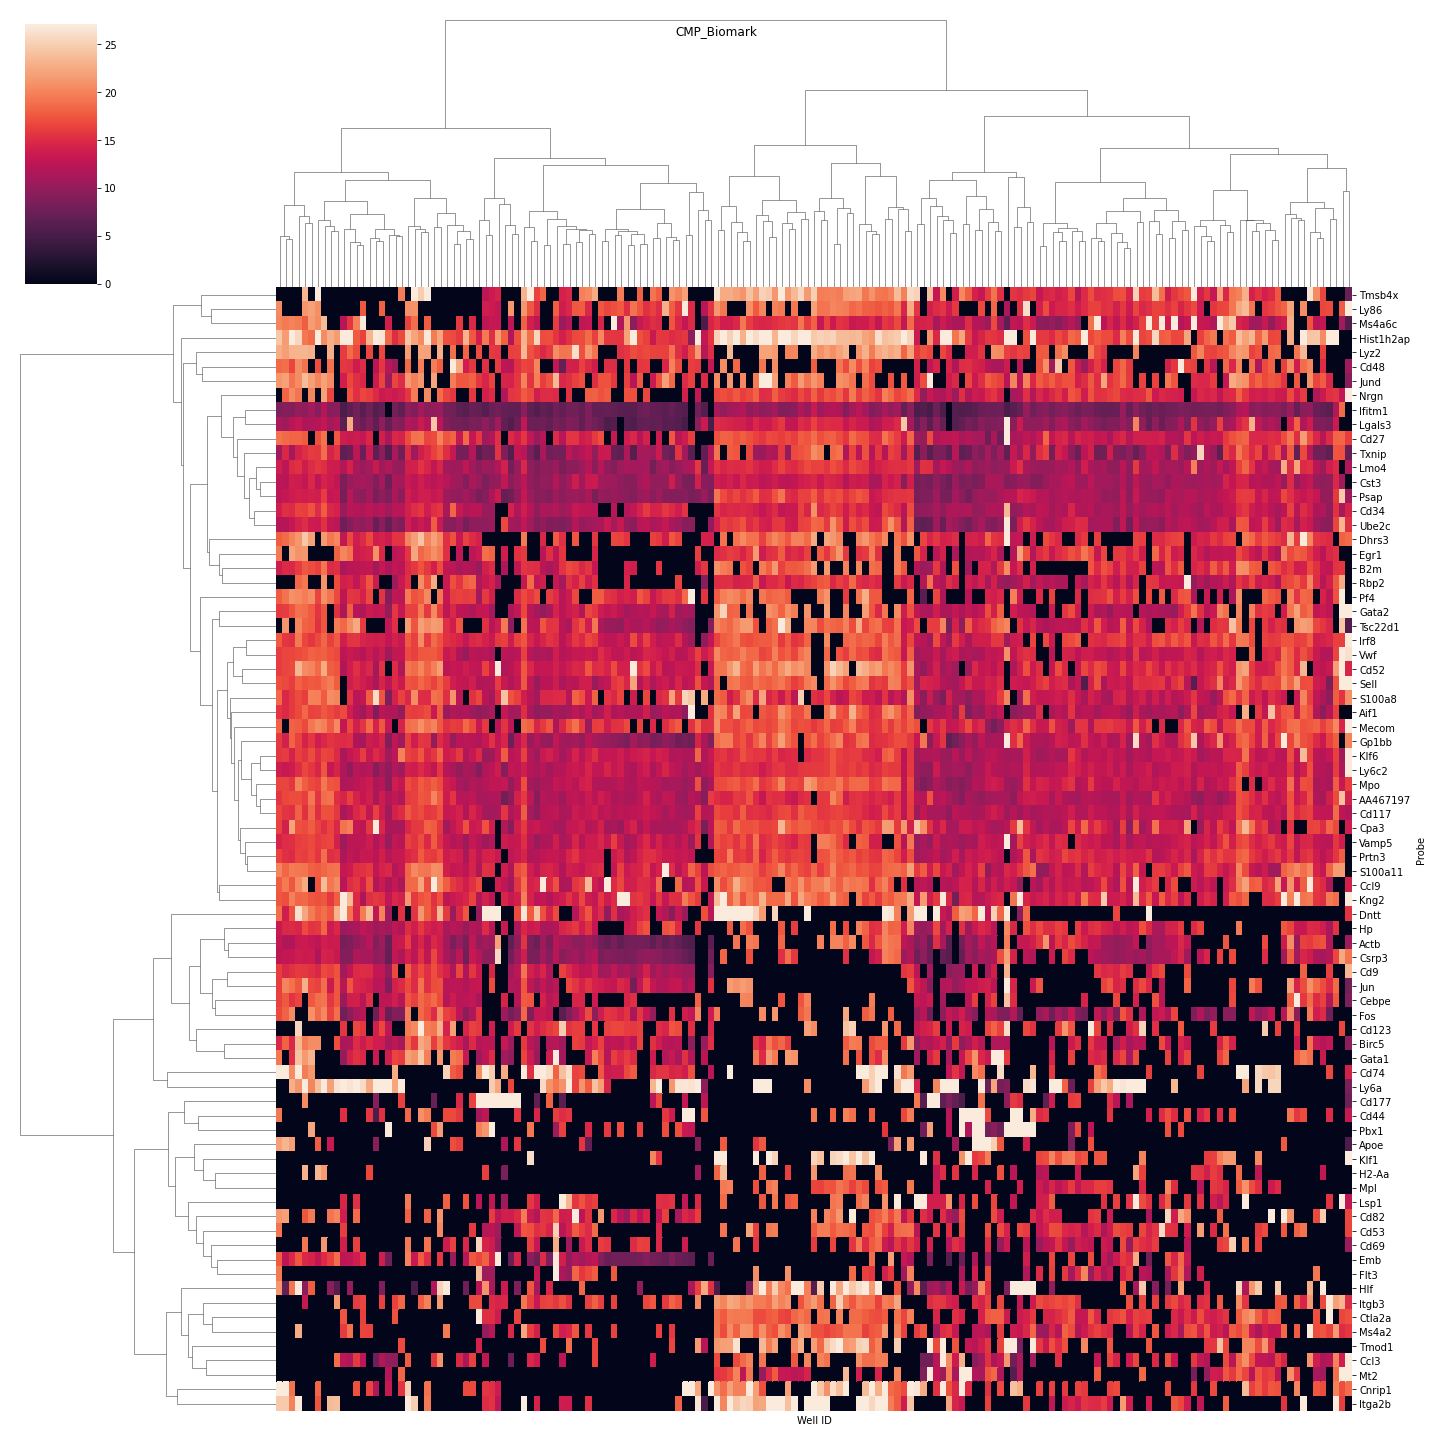

In [21]:
sns.clustermap(biomark.fillna(0).transpose(), method = 'ward', xticklabels = False, yticklabels = True, robust = True, figsize=(20,20)).fig.suptitle("CMP_Biomark")

In [11]:
biomark.max().max()

39.9597110812325

On average, how many genes are detected per cell in the biomark assay? 

In [12]:
len(biomark.columns) - biomark.isnull().sum(axis = 1).mean()

54.65269461077844

So on average approximately 55 of the 78 probes are detected in each cell.  
Use this value in the seurat.object subsetting for `nFeatures_RNA >= X`. Will round to ~50

#### dCt  
ref genes `ref_list = ["Actb", "B2m", "Cd117"]`

In [13]:
dbiomark = dCt(biomark)
# dbiomark = dCt_xprsn(dbiomark)
dbiomark = dbiomark.fillna(0)

In [14]:
dbiomark['id'] = 'biomark'

In [15]:
dbiomark.head(2)

Probe,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,...,S100a8,Sell,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,id
Well ID,,,,,,,,,,,,,,,,,,,,,
CMP_a1_p1,0.397845,-0.762792,0.458386,28.629114,0.000000,3.561568,-1.132644,1.646315,0.762792,0.0,...,1.504188,2.910428,2.124372,3.884586,3.842558,-0.613218,-0.533507,0.632748,0.853020,biomark
CMP_a2_p1,-2.723805,0.000000,-3.017012,0.000000,0.529171,0.000000,-4.969267,0.523014,-0.529171,0.0,...,0.000000,1.101495,23.766987,3.094573,0.000000,0.709287,-4.065883,-1.547669,0.242774,biomark


In [16]:
dbiomark[dbiomark.columns[:-1]].max().max()

31.397428199339398

Text(0.5, 0.98, 'CMP_Biomark')

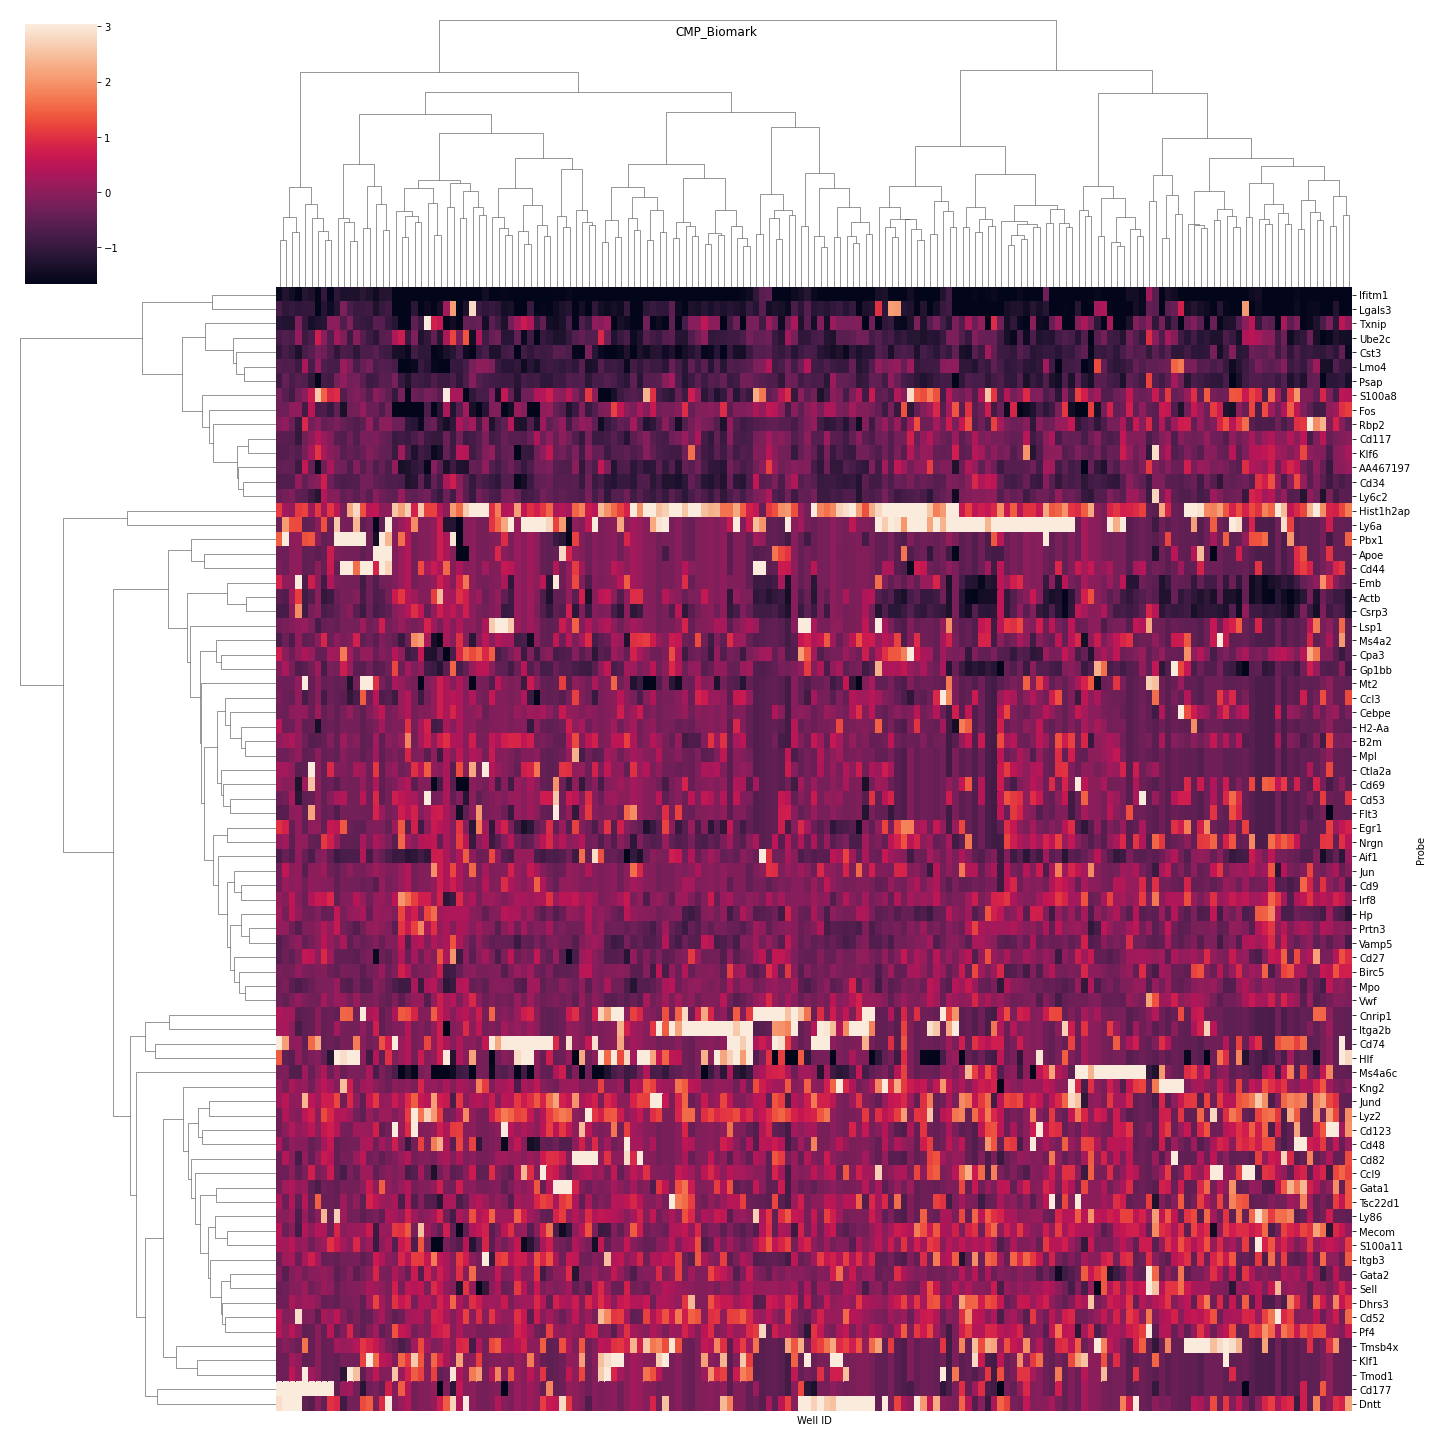

In [23]:
sns.clustermap(dbiomark[dbiomark.columns[:-1]].transpose(), method = 'ward', xticklabels = False, yticklabels = True, robust = True, figsize=(20,20), z_score=1).fig.suptitle("CMP_Biomark")

### SC experiment

#### SC count matrix
Note that single cell count matrix is the "counts" slot from Seurat v4 `seurat.object@assays$RNA@counts`

In [195]:
sc_cts = pd.read_table("/Users/heustonef/Desktop/10XGenomicsData/MergeBiomarkWith10X/CMPSubpop_vBiomark_Counts-BiomarkProbes.txt", sep="\t", index_col=0)
sc_cts = sc_cts.rename({"RNA_snn_res.0.5":"id"}, axis='columns')
sc_cts.head(n = 2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123,id
Row.names,,,,,,,,,,,,,,,,,,,,,
CMPm2_AAACATACCCAACA-1,0,14,0,10,56,7,0,5,0,1,...,0,58,6,2,8,5,0,2,0,2
CMPm2_AAACATTGGACTAC-1,0,10,0,21,26,0,0,6,2,0,...,0,22,3,2,0,4,0,0,0,3


In [196]:
sclog_cts = sc_cts.copy().drop(['Shisa5', 'Eef2', 'H2-Ab1', 'id'], axis = 1)
sclog_cts = np.log2(1/sclog_cts)
transform_factor = 5-sclog_cts.min().min()
sclog_cts = sclog_cts + transform_factor
sclog_cts[np.isinf(sclog_cts)] = np.nan
sclog_cts.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123
Row.names,,,,,,,,,,,,,,,,,,,,,
CMPm2_AAACATACCCAACA-1,NaN,11.371310,NaN,11.856737,9.371310,12.37131,NaN,12.856737,NaN,15.178665,...,NaN,NaN,9.320684,12.593702,14.178665,12.178665,12.856737,NaN,14.178665,NaN
CMPm2_AAACATTGGACTAC-1,NaN,11.856737,NaN,10.786347,10.478225,NaN,NaN,12.593702,14.178665,NaN,...,15.178665,NaN,10.719233,13.593702,14.178665,NaN,13.178665,NaN,NaN,NaN


##### dCt

In [197]:
dsclog_cts = dCt(sclog_cts)
# dsclog_cts = 2**-dsclog_cts
dsclog_cts = dsclog_cts.fillna(0)

In [198]:
# dsclog_cts['id'] = 'sc'
dsclog_cts['id'] = sc_cts['id']

In [118]:
pd.concat([dbiomark.describe().mean(axis = 1), dsclog_cts.describe().mean(axis = 1)], axis = 1)

,0,1
count,167.000000,147.000000
mean,1.089158,0.962837
std,3.273750,1.280668
min,-5.251637,-1.110918
25%,-0.653146,0.056725
50%,0.197476,0.669747
75%,2.048539,1.668924
max,18.155598,4.627074


In [119]:
merged_df = pd.concat([dbiomark, dsclog_cts], join = 'inner', axis = 0)

cell_id = merged_df.pop("id")
merged_df = merged_df.fillna(0)

lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

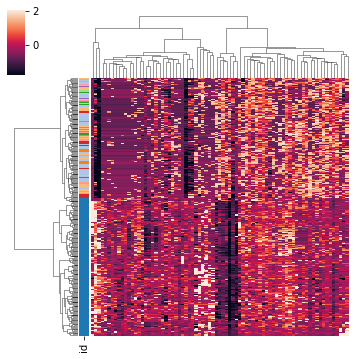

In [120]:
sns.clustermap(merged_df, method = 'ward', xticklabels = False, yticklabels = False, robust = True, row_colors = row_colors, figsize=(5,5), z_score=0)

#### SC data
Note that single cell count matrix is the "data" slot from Seurat v4 `seurat.object@assays$RNA@data`

In [510]:
sc_data = pd.read_table("/Users/heustonef/Desktop/10XGenomicsData/MergeBiomarkWith10X/CMPSubpop_vBiomark_Data-BiomarkProbes.txt", sep="\t", index_col=0)
sc_data = sc_data.rename({"RNA_snn_res.0.5":"id"}, axis='columns')
sc_data.head(n = 2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123,id
Row.names,,,,,,,,,,,,,,,,,,,,,
CMPm2_AAACCGTGGCTACA-1,0.0,6.058724,0.0,5.033303,7.081729,5.500860,0.0,6.363491,0.0,4.126741,...,0.0,6.884087,4.526813,0.000000,5.984796,4.811788,0.0,0.000000,0.0,2
CMPm2_AAACTTGACCTTCG-1,0.0,5.921313,0.0,6.026405,7.054471,4.828049,0.0,6.208324,0.0,0.000000,...,0.0,6.613118,3.745314,3.745314,6.208324,5.335669,0.0,3.745314,0.0,5


In [511]:
sc_data.shape

(300, 96)

In [512]:
cell_id = sc_data['id']
lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

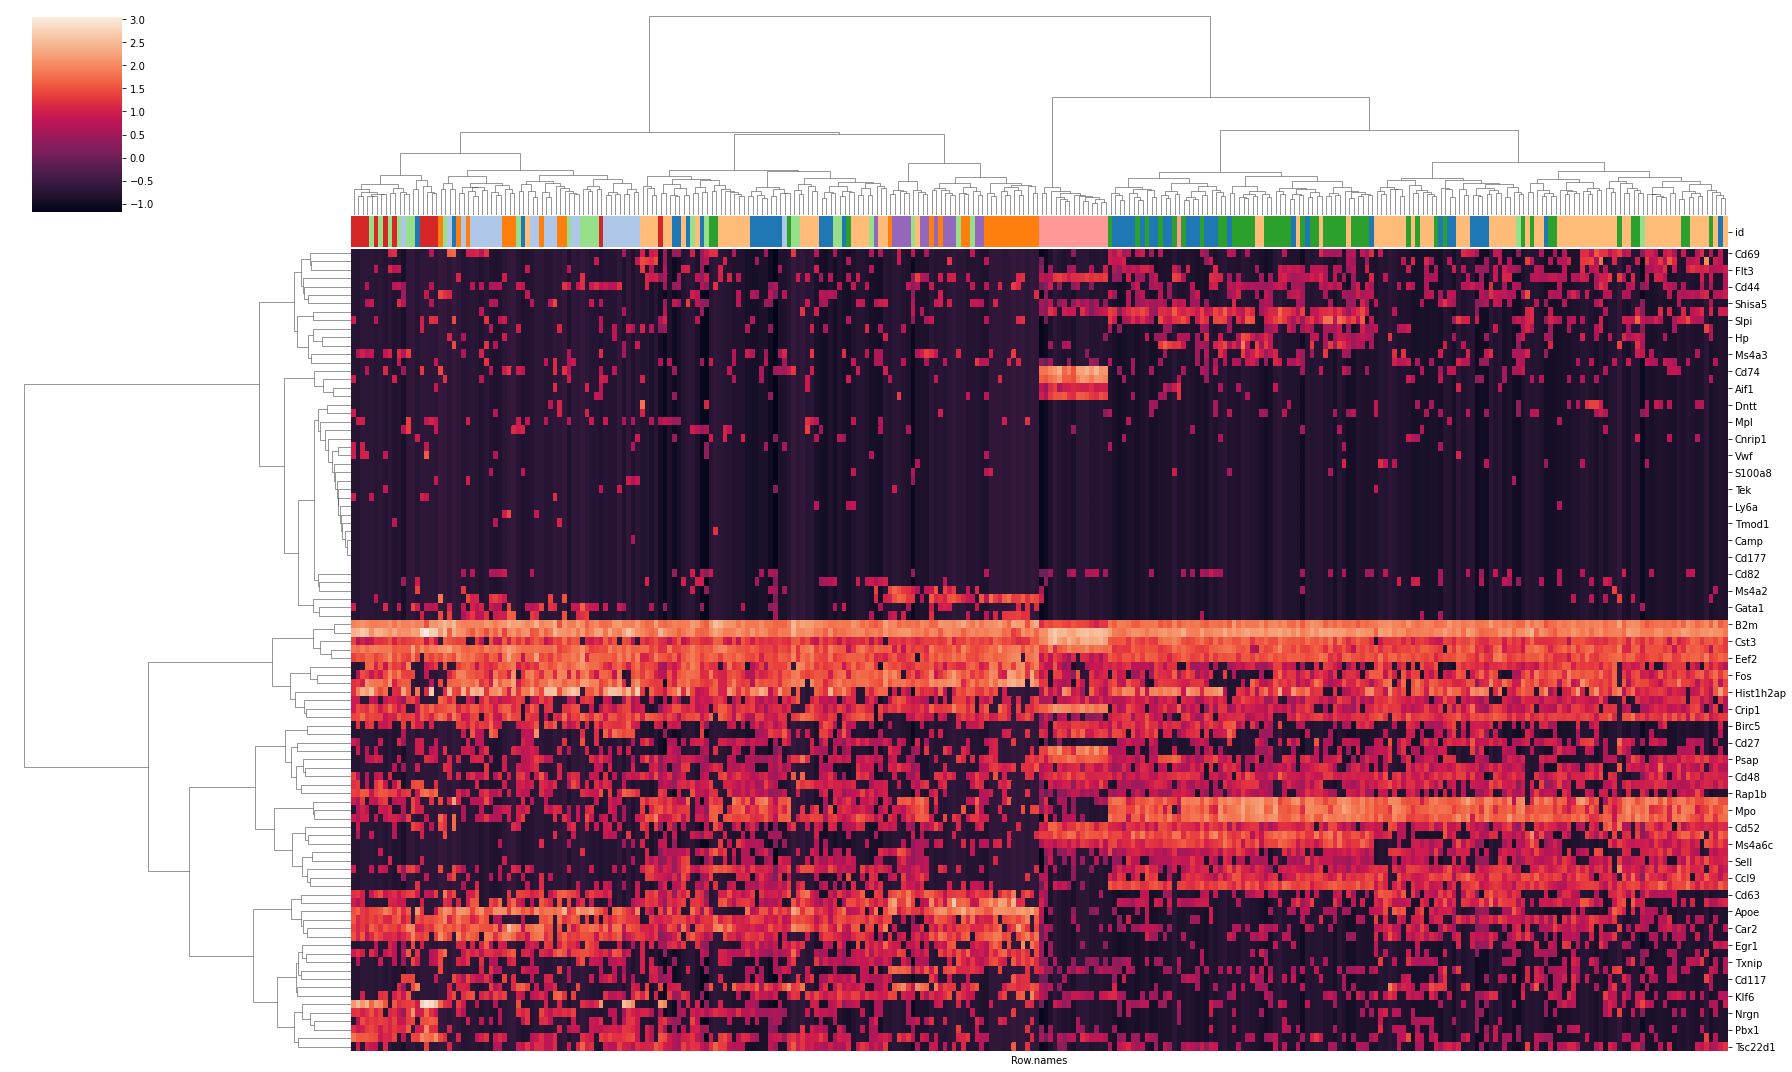

In [513]:
sns.clustermap(sc_data[sc_data.transpose().index[:-1]].transpose(), method = "ward", col_colors=row_colors, z_score = 1, xticklabels = False, figsize = (25, 15))

##### dCt

In [491]:
dsclog_data = dCt(sclog_data)
# dsclog_data = 2**-dsclog_data
dsclog_data = dsclog_data.fillna(0)

In [494]:
cell_id = sc_data['id']
lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

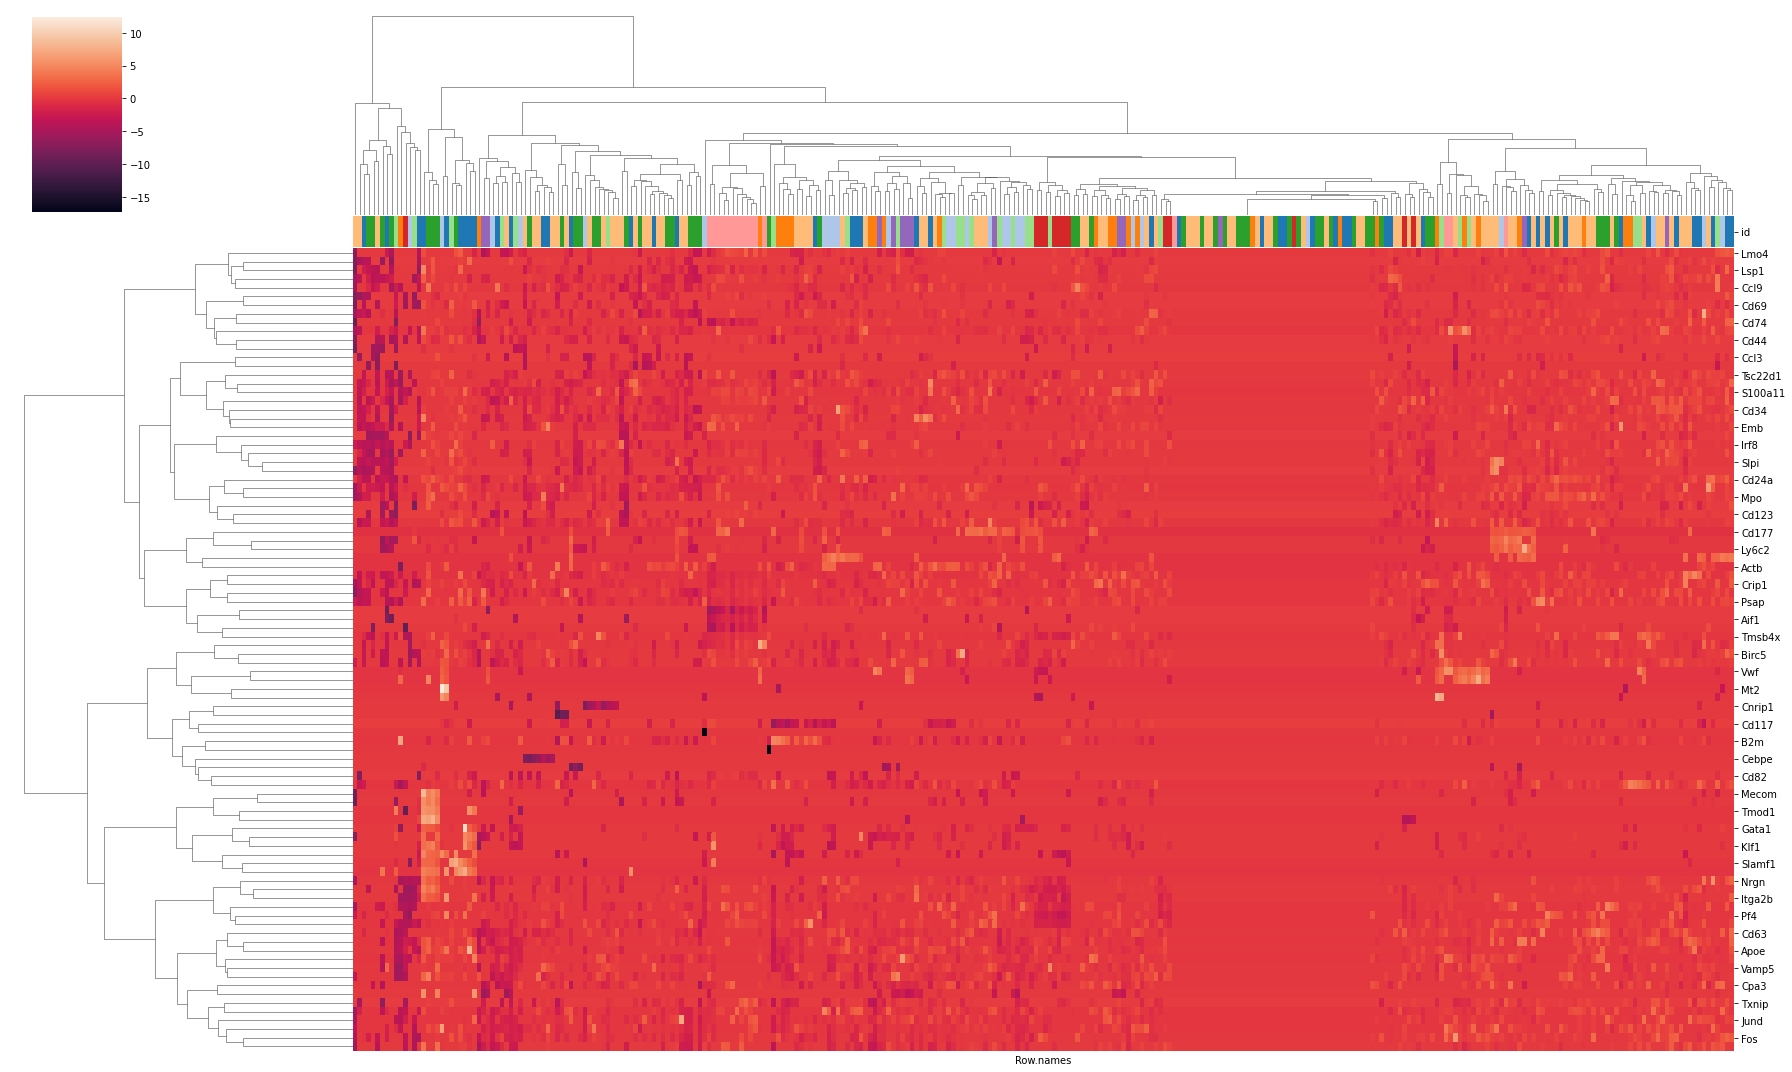

In [509]:
sns.clustermap(dsclog_data.transpose(), method = "ward", col_colors=row_colors, xticklabels = False, figsize = (25, 15), z_score=0)

#### SC scale.data
Note that single cell count matrix is the "scale.data" slot from Seurat v4 `seurat.object@assays$RNA@data`

In [497]:
sc_data = pd.read_table("/Users/heustonef/Desktop/10XGenomicsData/MergeBiomarkWith10X/CMPSubpop_vBiomark_ScaleData-BiomarkProbes.txt", sep="\t", index_col=0)
sc_data = sc_data.rename({"RNA_snn_res.0.5":"id"}, axis='columns')
sc_data.head(n = 2)

,Sell,Pbx1,Cd48,Slamf1,Cd34,Cd82,Cd44,Lmo2,B2m,AA467197,...,Aif1,Egr1,Cd74,Ms4a6c,Ms4a2,Ms4a3,Dntt,Gata1,Tmsb4x,id
Row.names,,,,,,,,,,,,,,,,,,,,,
CMPm2_AAACCGTGGCTACA-1,1.149651,0.084945,-0.112893,-0.169087,0.798937,2.708598,0.557492,-0.114616,0.773057,-0.032016,...,-0.192201,0.898248,-0.291809,-0.896561,2.109260,-0.641722,-0.328698,0.813991,-0.546830,2
CMPm2_AAACTTGACCTTCG-1,-0.703822,1.010707,-0.055194,-0.296734,0.002549,-0.357392,1.203312,0.604131,0.736399,-0.030517,...,-0.260400,-0.860219,0.497727,-0.290065,-0.349419,-0.484195,-0.301512,-0.784961,-0.602985,5


In [498]:
sc_data.shape

(300, 96)

In [499]:
cell_id = sc_data['id']
lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

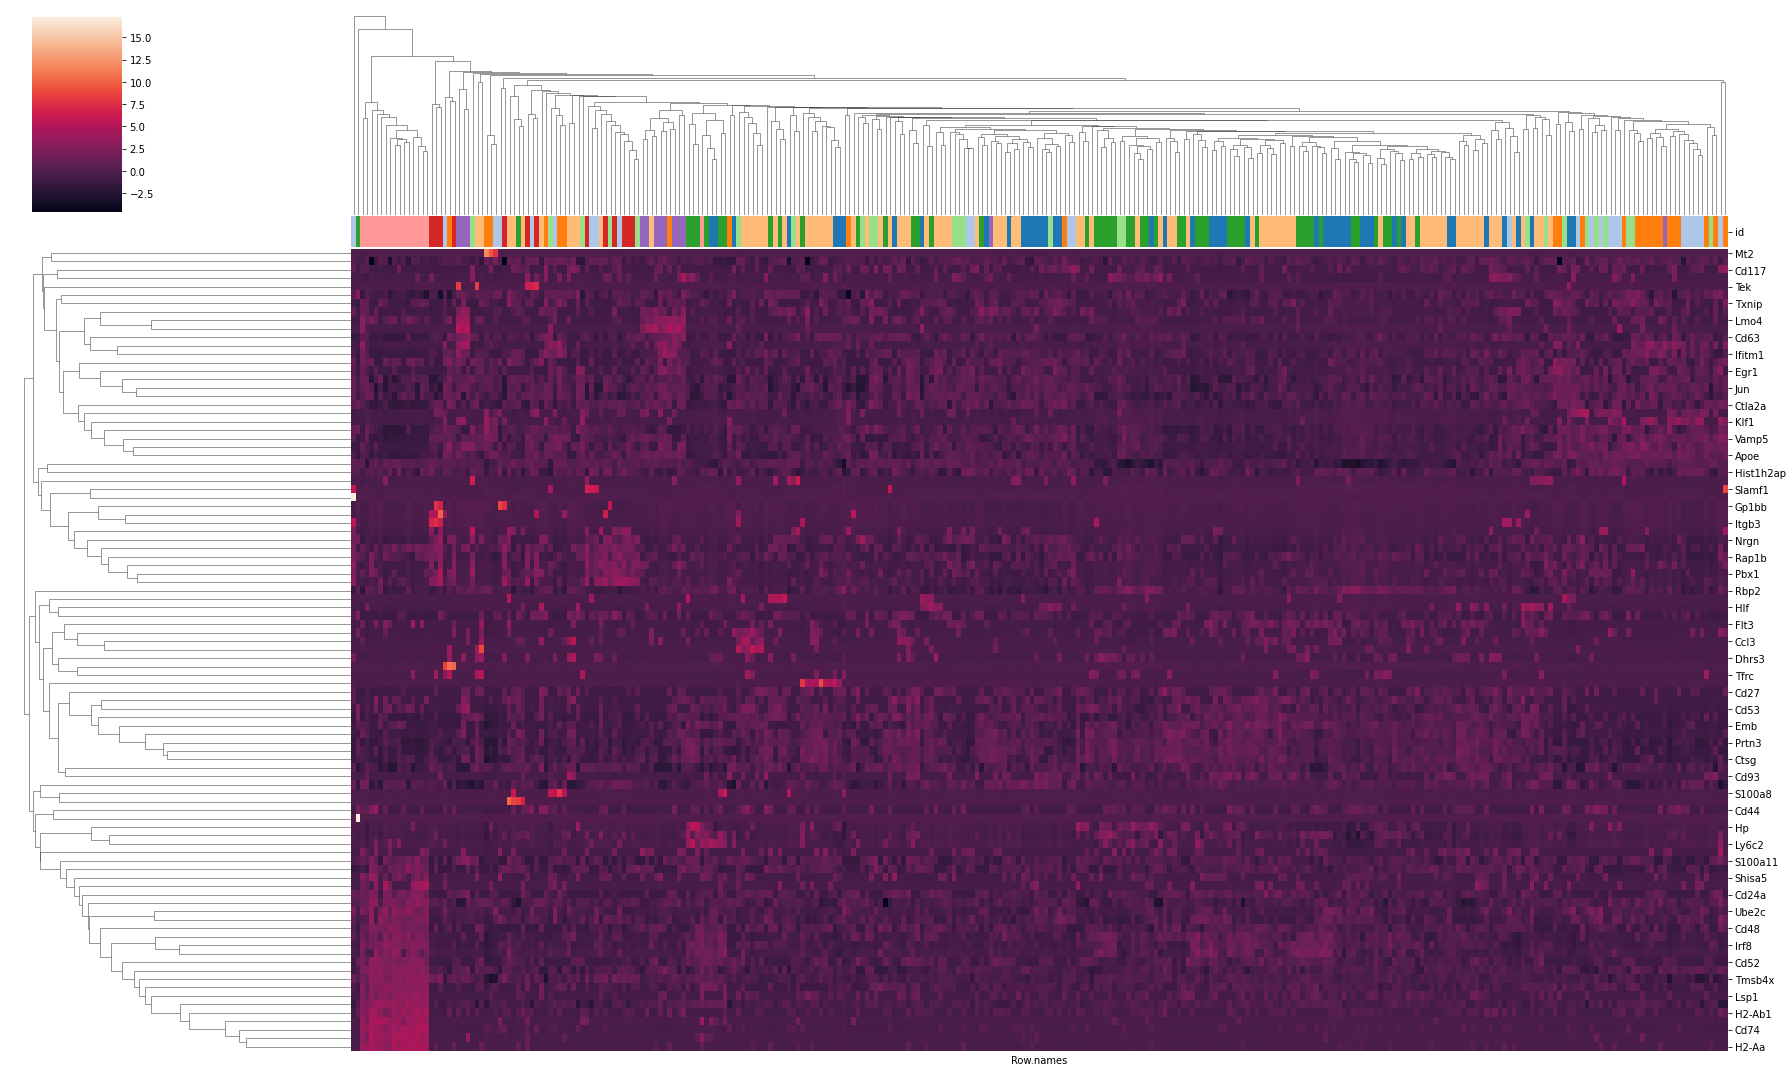

In [500]:
sns.clustermap(sc_data[sc_data.transpose().index[:-1]].transpose(), method = "average", col_colors=row_colors, xticklabels = False, figsize = (25, 15), z_score=0)

##### dCt

In [501]:
dsclog_data = dCt(sclog_data)
# dsclog_data = 2**-dsclog_data
dsclog_data = dsclog_data.fillna(0)

In [502]:
cell_id = sc_data['id']
lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

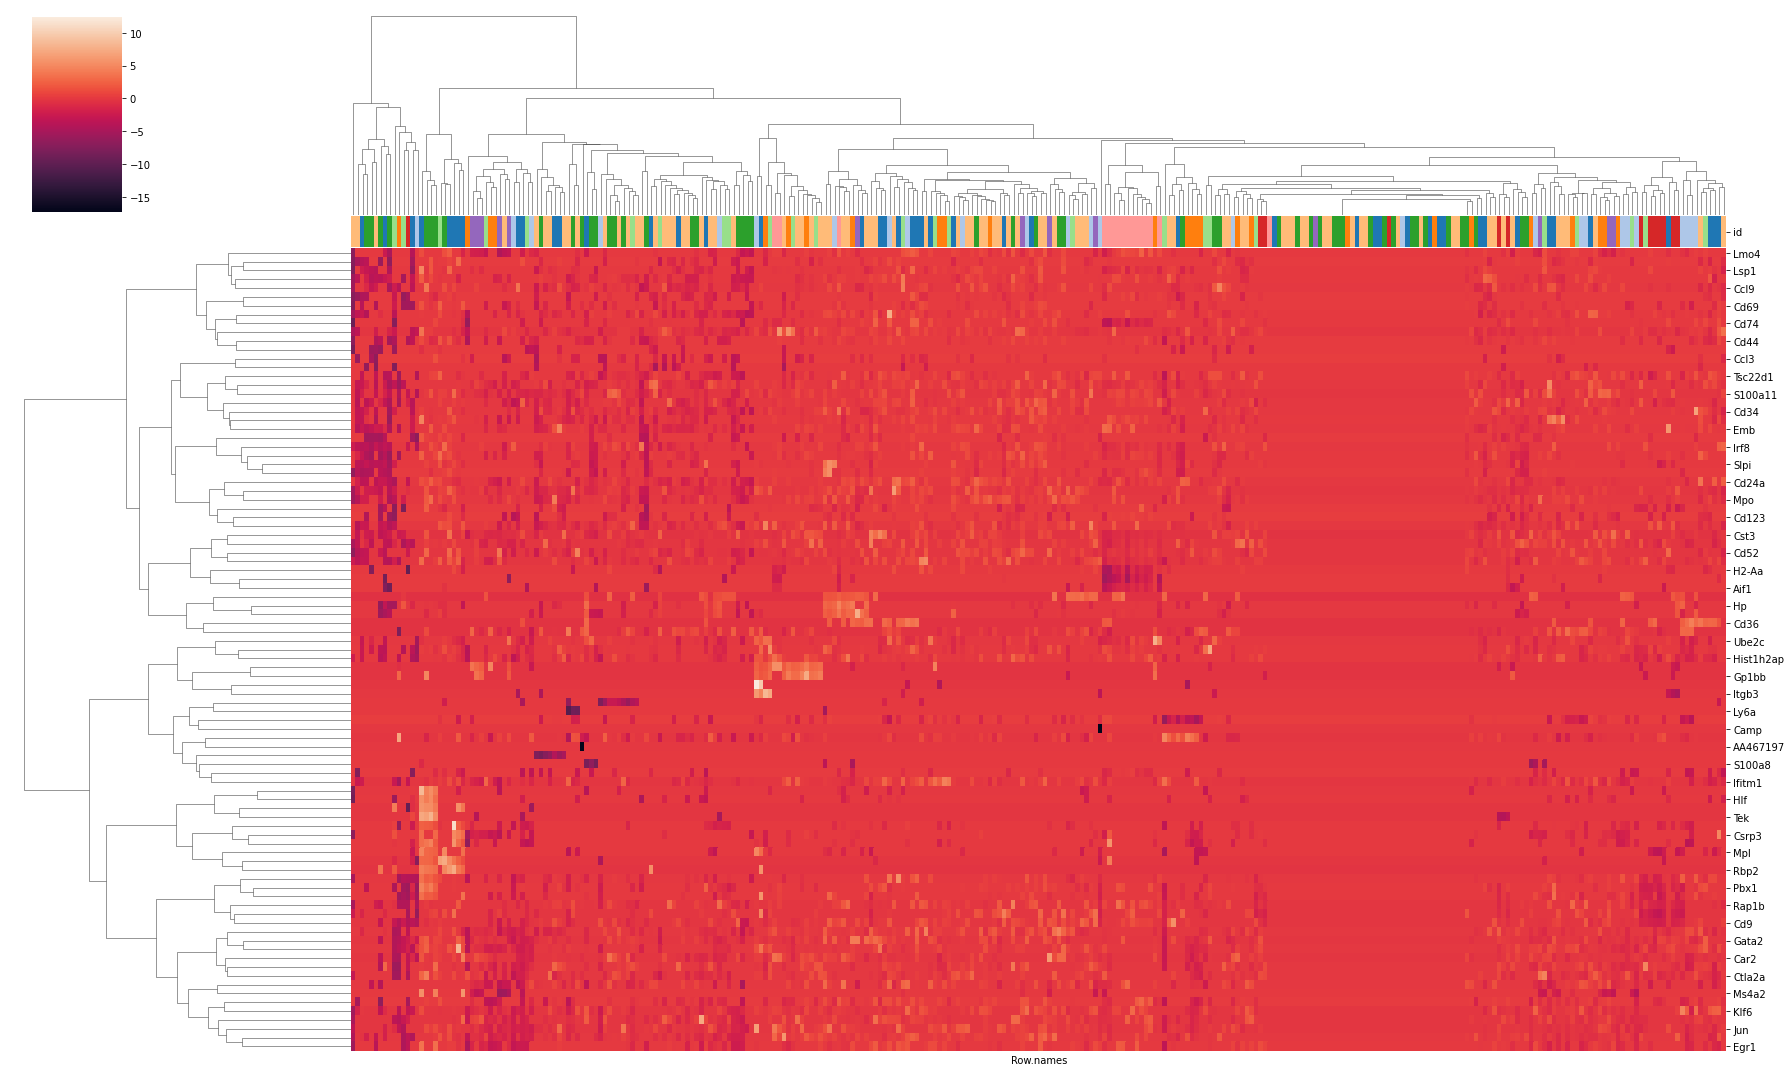

In [504]:
sns.clustermap(dsclog_data[dsclog_data.transpose().index[:-1]].transpose(), method = "ward", col_colors=row_colors, xticklabels = False, figsize = (25, 15), z_score=0)

In [477]:
dsclog_data = dCt(sclog_data)
# dsclog_data = 2**-dsclog_data
dsclog_data = dsclog_data.fillna(0)

In [244]:
dbiomark['id'] = 'biomark'
dsclog_data['id'] = 'sc'

In [232]:
pd.concat([dbiomark.describe().mean(axis = 1), dsclog_data.describe().mean(axis = 1)], axis = 1)

,0,1
count,167.000000,229.000000
mean,1.089158,0.188194
std,3.273750,0.274078
min,-5.251637,-0.255280
25%,-0.653146,-0.008410
50%,0.197476,0.113689
75%,2.048539,0.330081
max,18.155598,1.061353


In [233]:
merged_df = pd.concat([dbiomark, dsclog_data], join = 'inner', axis = 0)

cell_id = merged_df.pop("id")
merged_df = merged_df.fillna(0)

lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

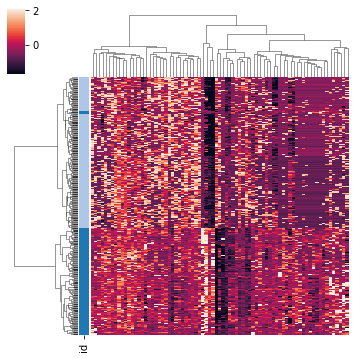

In [234]:
sns.clustermap(merged_df, method = 'ward', xticklabels = False, yticklabels = False, robust = True, row_colors = row_colors, figsize=(5,5), z_score=0)

## Merging

### Sklearn Scaling

In [43]:
from sklearn.preprocessing import RobustScaler
robustscaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25, 75))

In [44]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(1, 10))

In [50]:
ref_list = ['Actb', 'B2m', 'Cd117']

#### RobustScaler - dsclog_cts

In [206]:
dscrobust_cts =  pd.DataFrame(robustscaler.fit_transform(dsclog_cts.drop('id', axis = 1)), index = dsclog_cts.index, columns=dsclog_cts.columns[:-1]).fillna(0)
dscrobust_cts['id'] = sc_cts['id']
dscrobust_cts['tech'] = 'sc'
dbiomarkrobust = pd.DataFrame(robustscaler.fit_transform(dbiomark.drop('id', axis = 1)), index = dbiomark.index, columns=dbiomark.columns[:-1]).fillna(0)
dbiomarkrobust['id'] = 'biomark'
dbiomarkrobust['tech'] = 'biomark'

In [207]:
pd.concat([round(dscrobust_cts.describe().mean(axis = 1), 3), round(dbiomarkrobust.describe().mean(axis = 1), 3)], axis = 1)

,0,1
count,229.000,167.000
mean,0.215,0.506
std,0.739,2.016
min,-0.985,-3.073
25%,-0.245,-0.290
50%,0.022,0.000
75%,0.475,0.620
max,2.632,11.842


In [208]:
pd.concat([dscrobust_cts[ref_list].describe().mean(axis = 1), dbiomarkrobust[ref_list].describe().mean(axis = 1)], axis=1)

,0,1
count,229.000000,167.000000
mean,-0.002176,0.004425
std,0.566829,0.694852
min,-1.083120,-1.668057
25%,-0.519405,-0.549759
50%,0.000000,0.000000
75%,0.480595,0.450241
max,1.194441,1.993417


In [209]:
pal = ['#000000'] + sns.color_palette('tab10').as_hex()

dmerged_robust = pd.concat([dbiomarkrobust, dscrobust_cts], join = 'inner', axis = 0)

cell_id = dmerged_robust.pop("id")
tech_id = dmerged_robust.pop('tech')
dmerged_robust = dmerged_robust.fillna(0)

lut_cell = dict(zip(cell_id.unique(), pal))
row_colors_cell = cell_id.map(lut_cell)

lut_tech = dict(zip(tech_id.unique(), ['#000000', '#FFFFFF']))
row_colors_tech = tech_id.map(lut_tech)

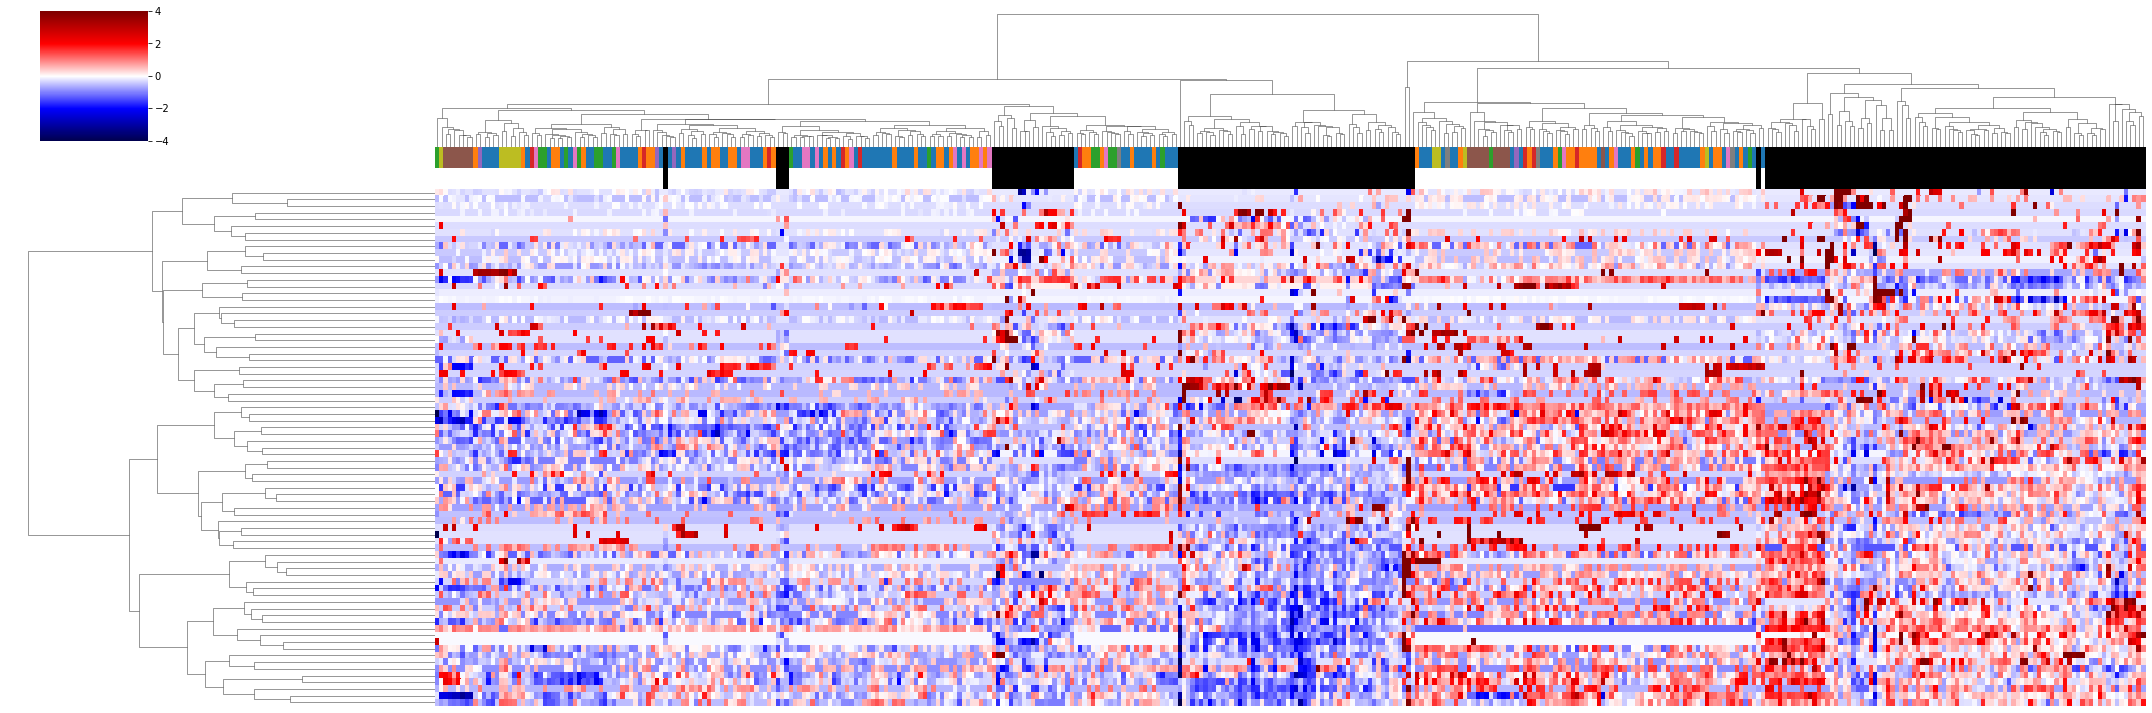

In [287]:
sns.clustermap(dmerged_robust.transpose(), method = 'ward', xticklabels = False, yticklabels = False, col_colors = [row_colors_cell, row_colors_tech], figsize=(30, 10), center = 0, cmap = "seismic", vmin = -4, vmax = 4, z_score=0)

#### RobustScaler - dsclog_data

In [279]:
dscrobust_data =  pd.DataFrame(robustscaler.fit_transform(dsclog_data.drop('id', axis = 1)), index = dsclog_data.index, columns=dsclog_data.columns[:-1]).fillna(0)
dscrobust_data['id'] = sc_data['id']
dscrobust_data['tech'] = 'sc'

dbiomarkrobust = pd.DataFrame(robustscaler.fit_transform(dbiomark.drop('id', axis = 1)), index = dbiomark.index, columns=dbiomark.columns[:-1]).fillna(0)
dbiomarkrobust['id'] = 'biomark'
dbiomarkrobust['tech'] = 'biomark'

In [280]:
pd.concat([round(dscrobust_data.describe().mean(axis = 1), 3), round(dbiomarkrobust.describe().mean(axis = 1), 3)], axis = 1)

,0,1
count,229.000,167.000
mean,0.189,0.506
std,0.590,2.016
min,-0.844,-3.073
25%,-0.228,-0.290
50%,0.022,0.000
75%,0.492,0.620
max,1.973,11.842


In [281]:
pd.concat([dscrobust_data[ref_list].describe().mean(axis = 1), dbiomarkrobust[ref_list].describe().mean(axis = 1)], axis=1)

,0,1
count,229.000000,167.000000
mean,0.019948,0.004425
std,0.557970,0.694852
min,-1.070455,-1.668057
25%,-0.484390,-0.549759
50%,0.000000,0.000000
75%,0.515610,0.450241
max,1.205302,1.993417


In [282]:
pal = ['#000000'] + sns.color_palette('tab10').as_hex()

dmergedrobust_data = pd.concat([dbiomarkrobust, dscrobust_data], join = 'inner', axis = 0)

cell_id = dmergedrobust_data.pop("id")
dmergedrobust_data = dmergedrobust_data.fillna(0)
lut_cell = dict(zip(cell_id.unique(), pal))
row_colors_cell = cell_id.map(lut_cell)

cell_id = dmergedrobust_data.pop("tech")
dmergedrobust_data = dmergedrobust_data.fillna(0)
lut = dict(zip(cell_id.unique(), ['#000000', '#FFFFFF']))
row_colors_tech = cell_id.map(lut_tech)

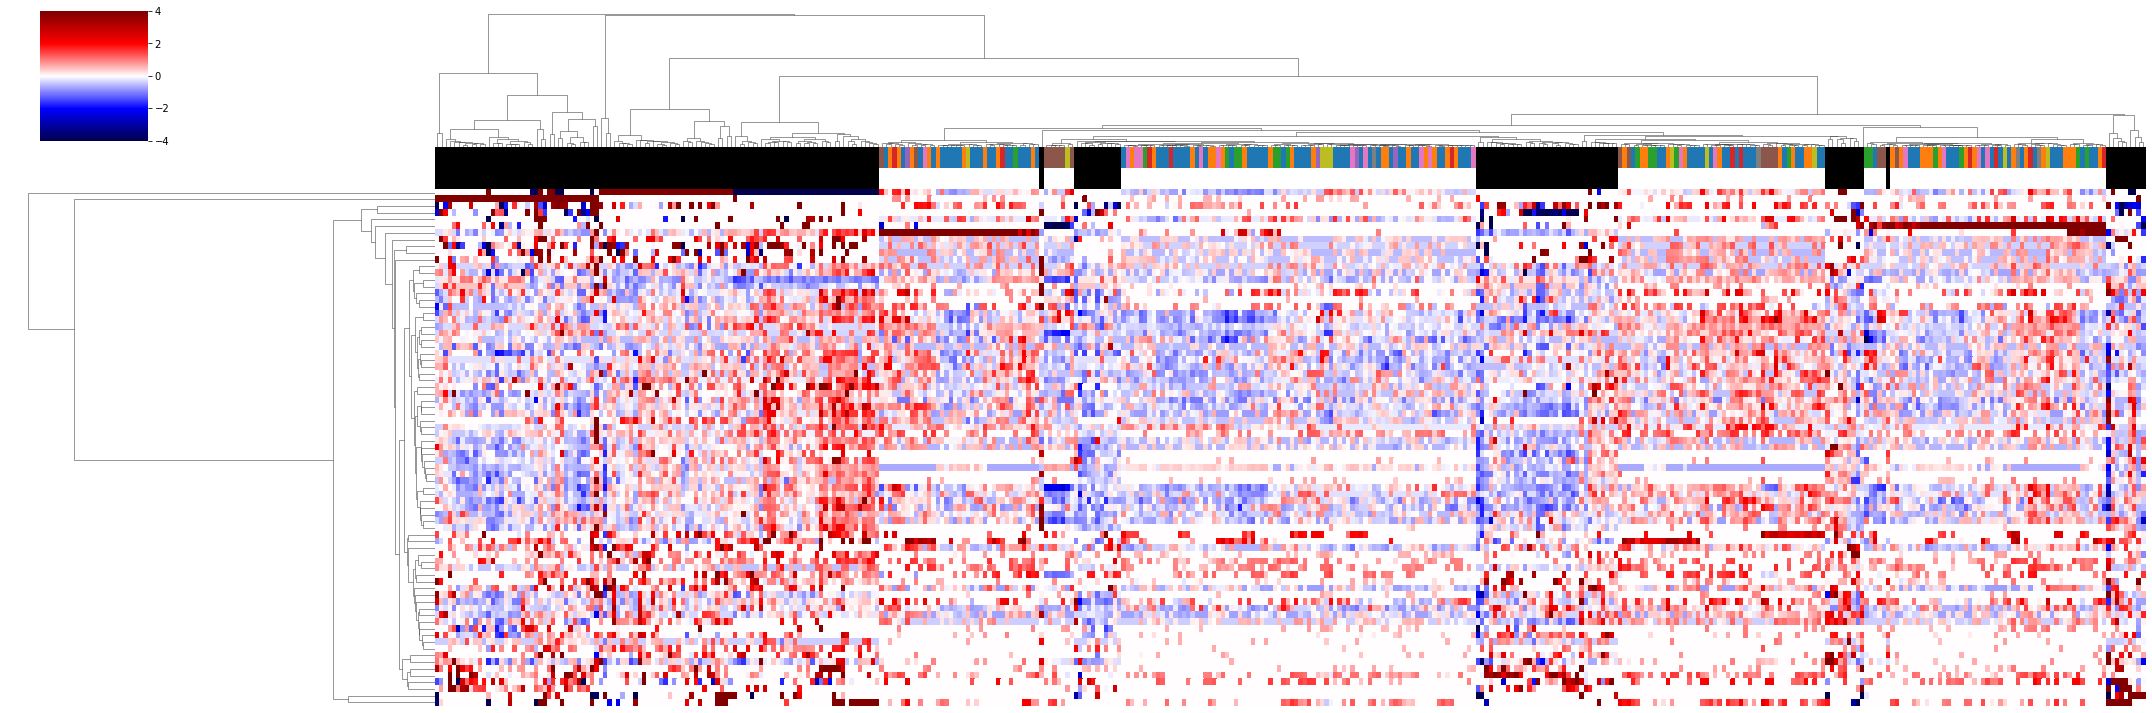

In [286]:
sns.clustermap(dmergedrobust_data.transpose(), method = 'ward', xticklabels = False, yticklabels = False, col_colors = [row_colors_cell, row_colors_tech], figsize=(30, 10), center = 0, cmap = "seismic", vmin = -4, vmax = 4)

#### RobustScaler - sclog

In [594]:
scrobust =  pd.DataFrame(robustscaler.fit_transform(sclog), index = sclog.index, columns=sclog.columns).fillna(0)
scrobust['id'] = 'sc'
biomarkrobust = pd.DataFrame(robustscaler.fit_transform(biomark), index = biomark.index, columns=biomark.columns).fillna(0)
biomarkrobust['id'] = 'biomark'

/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/heustonef/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [595]:
pd.concat([scrobust.describe().mean(axis = 1), biomarkrobust.describe().mean(axis = 1)], axis = 1)

,0,1
count,2.000000e+02,167.000000
mean,3.536338e-02,0.091428
std,5.364747e-01,0.680880
min,-1.538612e+00,-1.360211
25%,-1.901476e-01,-0.218467
50%,9.569970e-17,0.000000
75%,2.247548e-01,0.298597
max,2.150758e+00,3.511635


In [596]:
pd.concat([scrobust[ref_list].describe().mean(axis = 1), biomarkrobust[ref_list].describe().mean(axis = 1)], axis=1)

,0,1
count,2.000000e+02,167.000000
mean,1.002327e-01,0.093124
std,8.431724e-01,0.618736
min,-1.619784e+00,-1.135003
25%,-3.577360e-01,-0.310133
50%,1.151495e-15,0.000000
75%,3.867425e-01,0.427691
max,4.206244e+00,1.682698


In [597]:
pal = ['#000000'] + sns.color_palette('tab10').as_hex()

merged_robust = pd.concat([biomarkrobust, scrobust], join = 'inner', axis = 0)

cell_id = merged_robust.pop("id")
merged_robust = merged_robust.fillna(0)

lut = dict(zip(cell_id.unique(), pal))
row_colors = cell_id.map(lut)

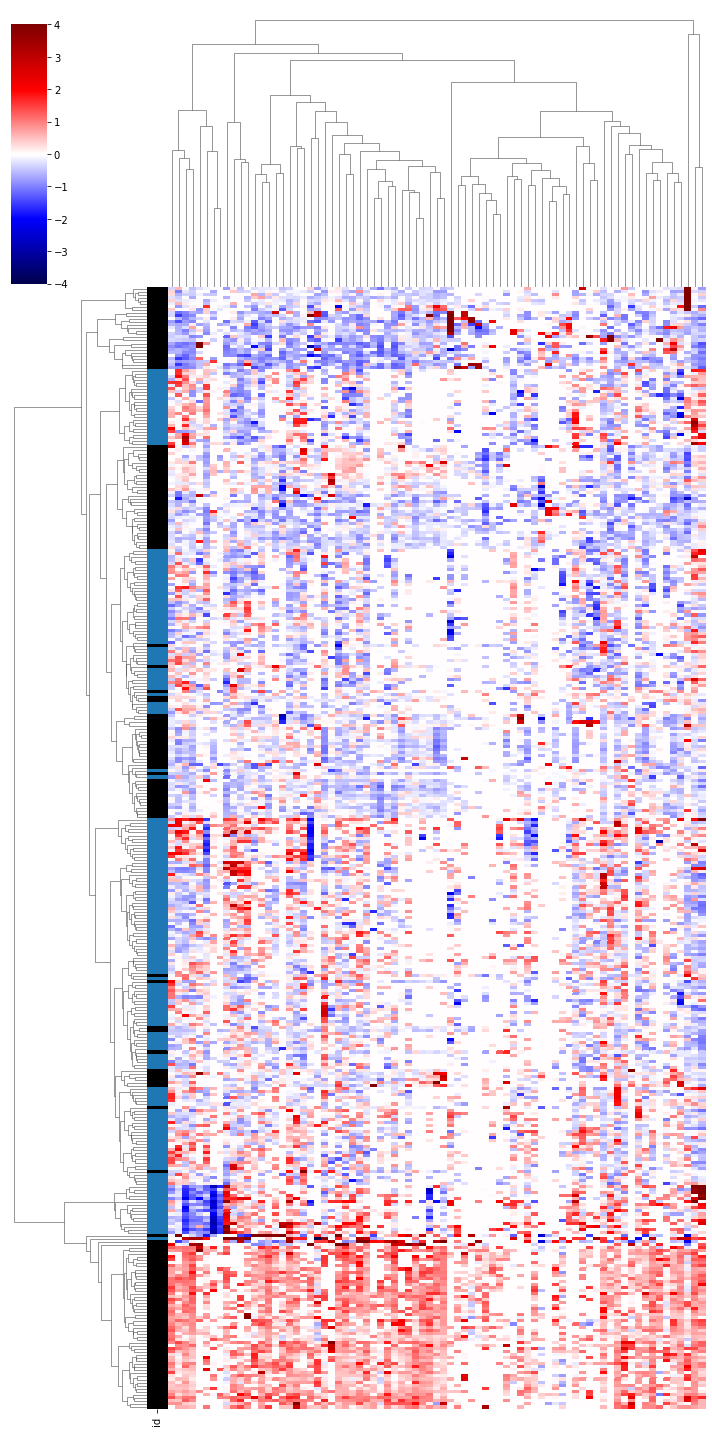

In [598]:
sns.clustermap(merged_robust, method = 'ward', xticklabels = False, yticklabels = False, row_colors = row_colors, figsize=(10, 20), center = 0, cmap = "seismic", vmin = -4, vmax = 4)

## LSK set

### Biomark experiment

In [335]:
biomark = rna.copy()
biomark = biomark[biomark.index.str.contains("LSK")]
biomark = biomark.drop(['Shisa5', 'Eef2', 'H2-Ab1'], axis = 1)
# biomark = biomark.fillna(0)

In [336]:
biomark.max().max()

39.8959143599615

On average, how many genes are detected per cell in the biomark assay? 

In [337]:
len(biomark.columns) - biomark.isnull().sum(axis = 1).mean()

51.952879581151834

So on average approximately 51 of the 78 probes are detected in each cell.  
Use this value in the seurat.object subsetting for `nFeatures_RNA >= X`. Will round to ~50

#### dCt  
ref genes `ref_list = ["Actb", "B2m", "Cd117"]`

In [338]:
dbiomark = dCt(biomark)
# dbiomark = dCt_xprsn(dbiomark)
dbiomark = dbiomark.fillna(0)

In [339]:
dbiomark.head(2)

Probe,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,...,S100a11,S100a8,Sell,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf
Well ID,,,,,,,,,,,,,,,,,,,,,
LSK_a9_p2,1.490432,-2.633067,-0.962152,-4.509490,1.538032,1.097719,0.0,11.065943,1.095035,4.822063,...,2.336574,3.668869,2.283055,0.0,0.0,2.557747,-2.792192,-2.902721,1.224887,1.147280
LSK_b10_p2,2.090868,-2.598889,1.875662,5.329759,0.000000,1.942007,0.0,11.812949,2.598889,6.322815,...,4.218366,0.000000,3.516963,0.0,0.0,0.166600,-3.658710,0.861646,3.629155,3.192709


In [340]:
dbiomark.max().max()

31.2446371016963

In [341]:
dbiomark['id'] = 'biomark'

### SC experiment

#### SC count matrix
Note that single cell count matrix is the "counts" slot from Seurat v4 `seurat.object@assays$RNA@counts`

In [342]:
sc_cts = pd.read_table("/Users/heustonef/Desktop/10XGenomicsData/MergeBiomarkWith10X/LSKSubpop_vBiomark_Counts-BiomarkProbes.txt", sep="\t", index_col=0)
sc_cts = sc_cts.rename({"RNA_snn_res.0.5":"id"}, axis='columns')
sc_cts.head(n = 2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123,id
Row.names,,,,,,,,,,,,,,,,,,,,,
LSKm2_AAACATACGATACC-1,0,13,0,0,31,7,0,10,0,0,...,0,13,4,3,1,3,0,1,2,2
LSKm2_AAACCGTGTTTGGG-1,0,7,0,3,38,0,0,10,10,0,...,0,46,4,2,0,3,0,1,0,7


In [343]:
sclog_cts = sc_cts.copy().drop(['Shisa5', 'Eef2', 'H2-Ab1', 'id'], axis = 1)
sclog_cts = np.log2(1/sclog_cts)
transform_factor = 5-sclog_cts.min().min()
sclog_cts = sclog_cts + transform_factor
sclog_cts[np.isinf(sclog_cts)] = np.nan
sclog_cts.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123
Row.names,,,,,,,,,,,,,,,,,,,,,
LSKm2_AAACATACGATACC-1,NaN,9.428843,NaN,NaN,8.175087,10.321928,NaN,9.807355,NaN,NaN,...,NaN,NaN,9.428843,11.129283,11.544321,13.129283,11.544321,NaN,13.129283,12.129283
LSKm2_AAACCGTGTTTGGG-1,NaN,10.321928,NaN,11.544321,7.881356,NaN,NaN,9.807355,9.807355,NaN,...,NaN,NaN,7.605721,11.129283,12.129283,NaN,11.544321,NaN,13.129283,NaN


##### dCt

In [344]:
dsclog_cts = dCt(sclog_cts)
# dsclog_cts = 2**-dsclog_cts
dsclog_cts = dsclog_cts.fillna(0)

In [345]:
# dsclog_cts['id'] = 'sc'
dsclog_cts['id'] = sc_cts['id']

In [346]:
pd.concat([dbiomark.describe().mean(axis = 1), dsclog_cts.describe().mean(axis = 1)], axis = 1)

,0,1
count,191.000000,235.000000
mean,0.141114,1.055100
std,3.185619,1.242796
min,-16.406165,-0.747325
25%,-0.964452,0.126491
50%,-0.338030,0.769596
75%,0.976280,1.853868
max,16.786872,4.807691


In [347]:
merged_df = pd.concat([dbiomark, dsclog_cts], join = 'inner', axis = 0)

cell_id = merged_df.pop("id")
merged_df = merged_df.fillna(0)

lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

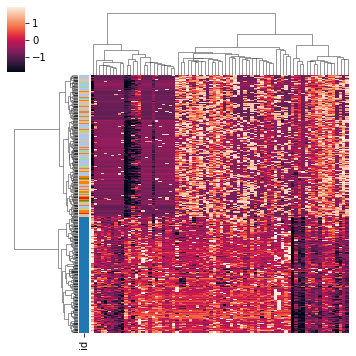

In [348]:
sns.clustermap(merged_df, method = 'ward', xticklabels = False, yticklabels = False, robust = True, row_colors = row_colors, figsize=(5,5), z_score=0)

#### SC data
Note that single cell count matrix is the "counts" slot from Seurat v4 `seurat.object@assays$RNA@data`

In [350]:
sc_data = pd.read_table("/Users/heustonef/Desktop/10XGenomicsData/MergeBiomarkWith10X/LSKSubpop_vBiomark_Data-BiomarkProbes.txt", sep="\t", index_col=0)
sc_data = sc_data.rename({"RNA_snn_res.0.5":"id"}, axis='columns')
sc_data.head(n = 2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123,id
Row.names,,,,,,,,,,,,,,,,,,,,,
LSKm2_AAACATACGATACC-1,0.0,5.592813,0.0,0.000000,6.459685,4.976961,0.0,5.331565,0.000000,0.0,...,0.0,5.592813,4.422503,4.138814,3.071588,4.138814,0.0,3.071588,3.741288,2
LSKm2_AAACCGTGTTTGGG-1,0.0,5.326314,0.0,4.485477,7.014015,0.000000,0.0,5.681529,5.681529,0.0,...,0.0,7.204914,4.770338,4.085632,0.000000,4.485477,0.0,3.409158,0.000000,7


In [351]:
sc_data.shape

(235, 95)

In [352]:
sclog_data = sc_data.copy().drop(['Shisa5', 'Eef2', 'H2-Ab1', 'id'], axis = 1)
sclog_data = np.log2(1/sclog_data)
transform_factor = 5-sclog_data.min().min()
sclog_data = sclog_data + transform_factor
sclog_data[np.isinf(sclog_data)] = np.nan
sclog_data.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123
Row.names,,,,,,,,,,,,,,,,,,,,,
LSKm2_AAACATACGATACC-1,NaN,5.599263,NaN,NaN,5.391374,5.767572,NaN,5.668278,NaN,NaN,...,NaN,NaN,5.599263,5.937974,6.033620,6.463853,6.033620,NaN,6.463853,6.179302
LSKm2_AAACCGTGTTTGGG-1,NaN,5.669700,NaN,5.917576,5.272597,NaN,NaN,5.576558,5.576558,NaN,...,NaN,NaN,5.233856,5.828746,6.052278,NaN,5.917576,NaN,6.313422,NaN


##### dCt

In [353]:
dsclog_data = dCt(sclog_data)
# dsclog_data = 2**-dsclog_data
dsclog_data = dsclog_data.fillna(0)

In [354]:
dbiomark['id'] = 'biomark'
dsclog_data['id'] = 'sc'

In [355]:
pd.concat([dbiomark.describe().mean(axis = 1), dsclog_data.describe().mean(axis = 1)], axis = 1)

,0,1
count,191.000000,235.000000
mean,0.141114,0.196331
std,3.185619,0.254883
min,-16.406165,-0.160902
25%,-0.964452,0.004438
50%,-0.338030,0.127653
75%,0.976280,0.357367
max,16.786872,1.010676


In [356]:
merged_df = pd.concat([dbiomark, dsclog_data], join = 'inner', axis = 0)

cell_id = merged_df.pop("id")
merged_df = merged_df.fillna(0)

lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

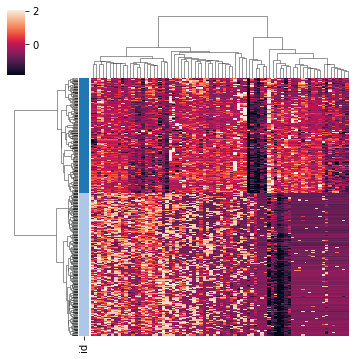

In [357]:
sns.clustermap(merged_df, method = 'ward', xticklabels = False, yticklabels = False, robust = True, row_colors = row_colors, figsize=(5,5), z_score=0)

## Merging

### Sklearn Scaling

In [358]:
from sklearn.preprocessing import RobustScaler
robustscaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25, 75))

In [359]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(1, 10))

In [360]:
ref_list = ['Actb', 'B2m', 'Cd117']

#### RobustScaler - dsclog_cts

In [362]:
dscrobust_cts =  pd.DataFrame(robustscaler.fit_transform(dsclog_cts.drop('id', axis = 1)), index = dsclog_cts.index, columns=dsclog_cts.columns[:-1]).fillna(0)
dscrobust_cts['id'] = sc_cts['id']
dscrobust_cts['tech'] = 'sc'
dbiomarkrobust = pd.DataFrame(robustscaler.fit_transform(dbiomark.drop('id', axis = 1)), index = dbiomark.index, columns=dbiomark.columns[:-1]).fillna(0)
dbiomarkrobust['id'] = 'biomark'
dbiomarkrobust['tech'] = 'biomark'

In [364]:
pd.concat([round(dscrobust_cts.describe().mean(axis = 1), 3), round(dbiomarkrobust.describe().mean(axis = 1), 3)], axis = 1)

,0,1
count,235.000,191.000
mean,0.179,0.306
std,0.677,2.789
min,-0.728,-15.428
25%,-0.245,-0.289
50%,0.022,0.000
75%,0.494,0.570
max,2.653,18.133


In [365]:
pd.concat([dscrobust_cts[ref_list].describe().mean(axis = 1), dbiomarkrobust[ref_list].describe().mean(axis = 1)], axis=1)

,0,1
count,235.000000,191.000000
mean,0.059148,0.272660
std,0.537921,1.021109
min,-0.892474,-4.778322
25%,-0.468903,-0.174984
50%,0.000000,0.000000
75%,0.531097,0.825016
max,1.148979,4.237902


In [366]:
pal = ['#000000'] + sns.color_palette('tab10').as_hex()

dmerged_robust = pd.concat([dbiomarkrobust, dscrobust_cts], join = 'inner', axis = 0)

cell_id = dmerged_robust.pop("id")
tech_id = dmerged_robust.pop('tech')
dmerged_robust = dmerged_robust.fillna(0)

lut_cell = dict(zip(cell_id.unique(), pal))
row_colors_cell = cell_id.map(lut_cell)

lut_tech = dict(zip(tech_id.unique(), ['#000000', '#FFFFFF']))
row_colors_tech = tech_id.map(lut_tech)

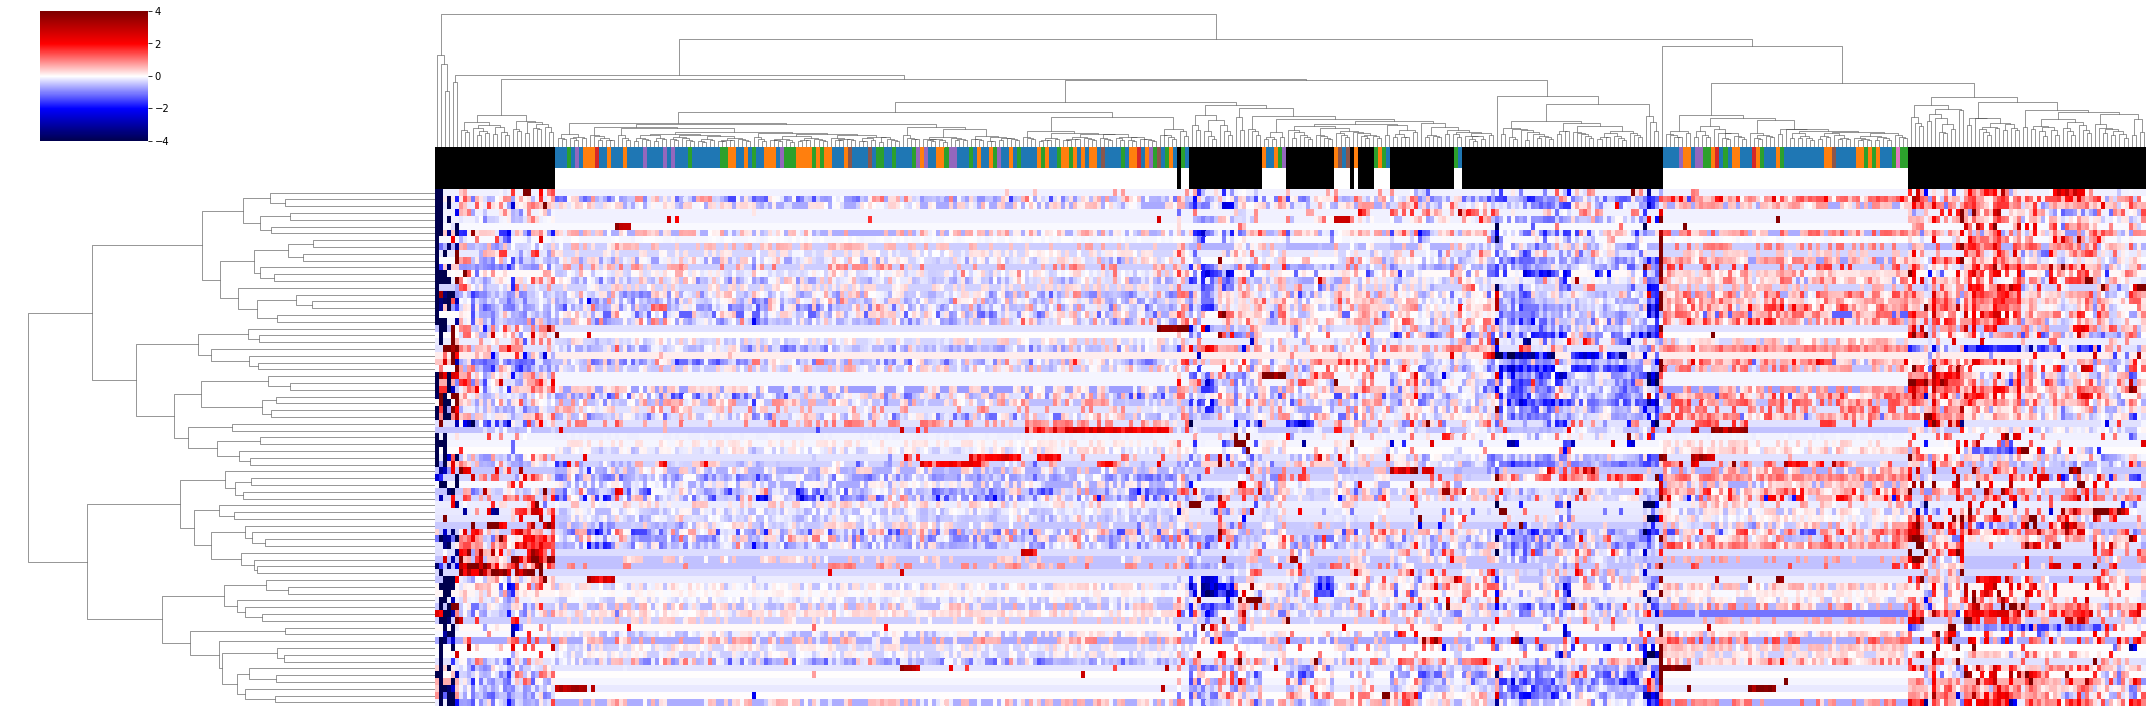

In [367]:
sns.clustermap(dmerged_robust.transpose(), method = 'ward', xticklabels = False, yticklabels = False, col_colors = [row_colors_cell, row_colors_tech], figsize=(30, 10), center = 0, cmap = "seismic", vmin = -4, vmax = 4, z_score=0)

#### RobustScaler - dsclog_data

In [368]:
dscrobust_data =  pd.DataFrame(robustscaler.fit_transform(dsclog_data.drop('id', axis = 1)), index = dsclog_data.index, columns=dsclog_data.columns[:-1]).fillna(0)
dscrobust_data['id'] = sc_data['id']
dscrobust_data['tech'] = 'sc'

dbiomarkrobust = pd.DataFrame(robustscaler.fit_transform(dbiomark.drop('id', axis = 1)), index = dbiomark.index, columns=dbiomark.columns[:-1]).fillna(0)
dbiomarkrobust['id'] = 'biomark'
dbiomarkrobust['tech'] = 'biomark'

In [369]:
pd.concat([round(dscrobust_data.describe().mean(axis = 1), 3), round(dbiomarkrobust.describe().mean(axis = 1), 3)], axis = 1)

,0,1
count,235.000,191.000
mean,0.178,0.306
std,0.549,2.789
min,-0.658,-15.428
25%,-0.224,-0.289
50%,0.022,0.000
75%,0.516,0.570
max,1.772,18.133


In [370]:
pd.concat([dscrobust_data[ref_list].describe().mean(axis = 1), dbiomarkrobust[ref_list].describe().mean(axis = 1)], axis=1)

,0,1
count,235.000000,191.000000
mean,0.071225,0.272660
std,0.513365,1.021109
min,-0.795103,-4.778322
25%,-0.440726,-0.174984
50%,0.000000,0.000000
75%,0.559274,0.825016
max,1.087337,4.237902


In [371]:
pal = ['#000000'] + sns.color_palette('tab10').as_hex()

dmergedrobust_data = pd.concat([dbiomarkrobust, dscrobust_data], join = 'inner', axis = 0)

cell_id = dmergedrobust_data.pop("id")
dmergedrobust_data = dmergedrobust_data.fillna(0)
lut_cell = dict(zip(cell_id.unique(), pal))
row_colors_cell = cell_id.map(lut_cell)

cell_id = dmergedrobust_data.pop("tech")
dmergedrobust_data = dmergedrobust_data.fillna(0)
lut = dict(zip(cell_id.unique(), ['#000000', '#FFFFFF']))
row_colors_tech = cell_id.map(lut_tech)

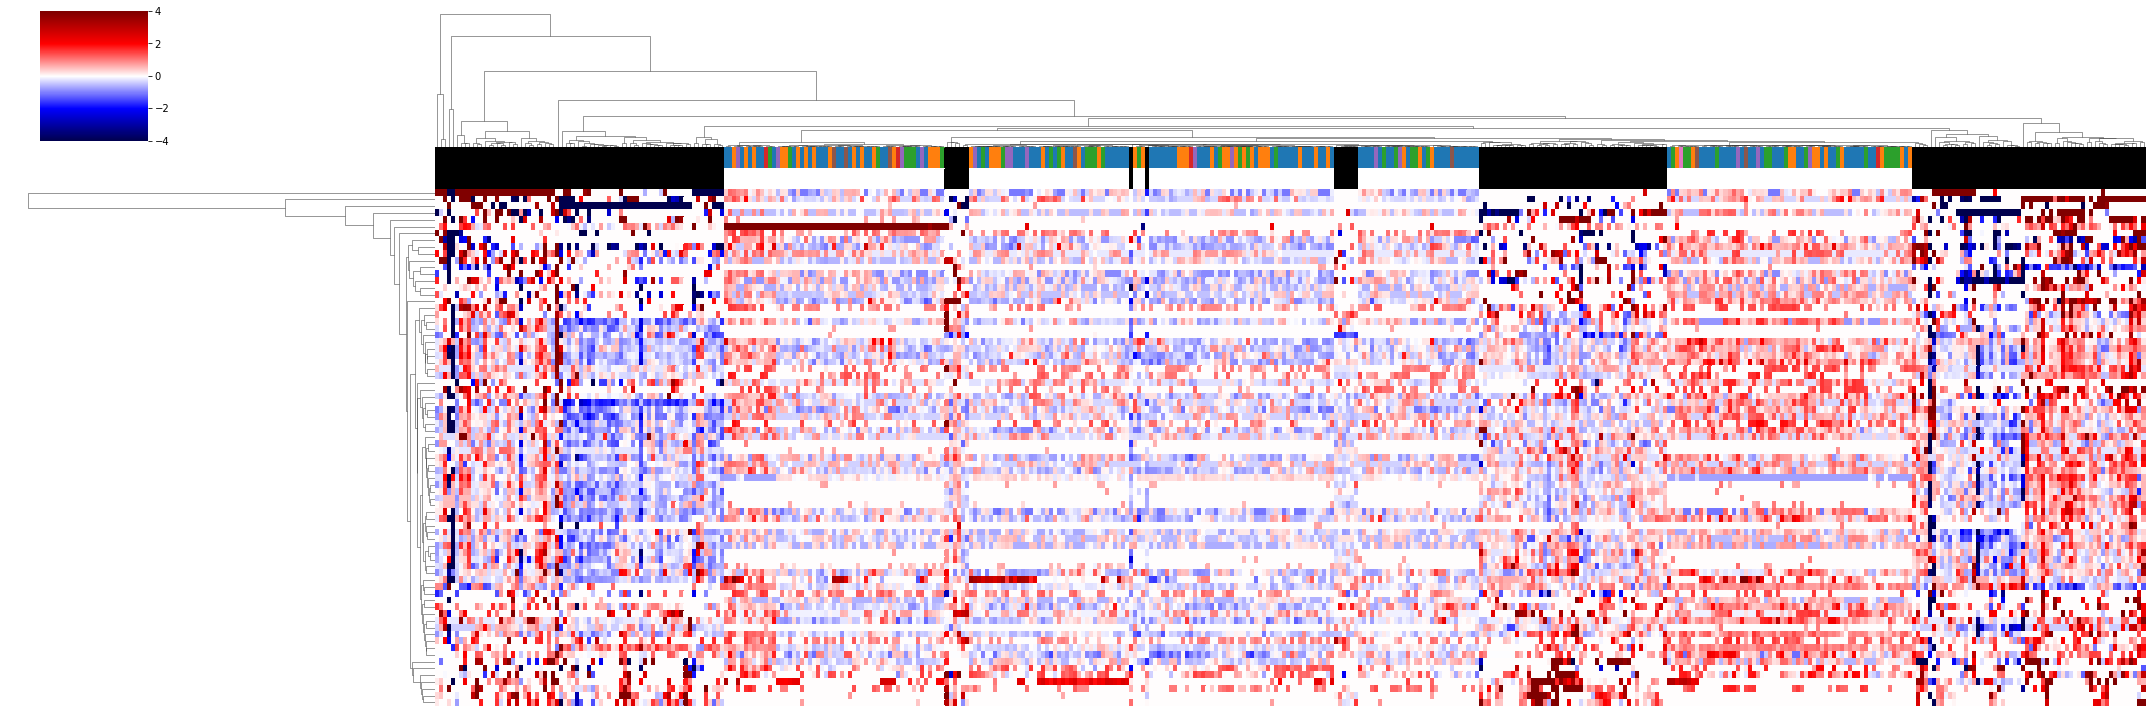

In [372]:
sns.clustermap(dmergedrobust_data.transpose(), method = 'ward', xticklabels = False, yticklabels = False, col_colors = [row_colors_cell, row_colors_tech], figsize=(30, 10), center = 0, cmap = "seismic", vmin = -4, vmax = 4)

## MEP set

### Biomark experiment

In [373]:
biomark = rna.copy()
biomark = biomark[biomark.index.str.contains("MEP")]
biomark = biomark.drop(['Shisa5', 'Eef2', 'H2-Ab1'], axis = 1)
# biomark = biomark.fillna(0)

In [374]:
biomark.max().max()

39.9493897557423

On average, how many genes are detected per cell in the biomark assay? 

In [375]:
len(biomark.columns) - biomark.isnull().sum(axis = 1).mean()

51.72727272727273

So on average approximately 55 of the 78 probes are detected in each cell.  
Use this value in the seurat.object subsetting for `nFeatures_RNA >= X`. Will round to ~50

#### dCt  
ref genes `ref_list = ["Actb", "B2m", "Cd117"]`

In [376]:
dbiomark = dCt(biomark)
# dbiomark = dCt_xprsn(dbiomark)
dbiomark = dbiomark.fillna(0)

In [377]:
dbiomark['id'] = 'biomark'

In [378]:
dbiomark.head(2)

Probe,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Ccl3,Ccl9,Cd117,Cd123,...,S100a8,Sell,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,id
Well ID,,,,,,,,,,,,,,,,,,,,,
MEP_a10_p1,0.710498,-1.178882,-2.117087,0.0,-0.426626,0.729414,0.000000,1.379838,1.605508,4.971611,...,7.795441,0.842979,0.0,0.0,4.699316,-4.161036,-3.141015,1.773079,0.626758,biomark
MEP_a11_p1,0.426821,-2.654558,17.800949,0.0,0.000000,1.836442,-3.739592,3.173005,2.654558,0.000000,...,6.500070,3.421626,0.0,0.0,0.566006,-2.382382,3.627770,5.261853,3.678826,biomark


In [379]:
dbiomark.max().max()

TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'str'

### SC experiment

#### SC count matrix
Note that single cell count matrix is the "counts" slot from Seurat v4 `seurat.object@assays$RNA@counts`

In [380]:
sc_cts = pd.read_table("/Users/heustonef/Desktop/10XGenomicsData/MergeBiomarkWith10X/MEPSubpop_vBiomark_Counts-BiomarkProbes.txt", sep="\t", index_col=0)
sc_cts = sc_cts.rename({"RNA_snn_res.0.5":"id"}, axis='columns')
sc_cts.head(n = 2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123,id
Row.names,,,,,,,,,,,,,,,,,,,,,
MEPm_AAACTTGAGAATAG-1,0,34,0,1,51,15,0,87,0,0,...,0,3,2,1,14,7,0,0,0,1
MEPm_AAAGAGACGGAAGC-1,0,11,0,0,18,0,0,8,0,0,...,0,80,1,0,0,2,1,0,0,6


In [381]:
sclog_cts = sc_cts.copy().drop(['Shisa5', 'Eef2', 'H2-Ab1', 'id'], axis = 1)
sclog_cts = np.log2(1/sclog_cts)
transform_factor = 5-sclog_cts.min().min()
sclog_cts = sclog_cts + transform_factor
sclog_cts[np.isinf(sclog_cts)] = np.nan
sclog_cts.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123
Row.names,,,,,,,,,,,,,,,,,,,,,
MEPm_AAACTTGAGAATAG-1,NaN,7.197939,NaN,12.285402,6.612977,8.378512,NaN,5.842459,NaN,NaN,...,12.285402,NaN,10.700440,11.285402,12.285402,8.478047,9.478047,NaN,NaN,NaN
MEPm_AAAGAGACGGAAGC-1,NaN,8.825971,NaN,NaN,8.115477,NaN,NaN,9.285402,NaN,NaN,...,NaN,NaN,5.963474,12.285402,NaN,NaN,11.285402,12.285402,NaN,NaN


##### dCt

In [382]:
dsclog_cts = dCt(sclog_cts)
# dsclog_cts = 2**-dsclog_cts
dsclog_cts = dsclog_cts.fillna(0)

In [383]:
# dsclog_cts['id'] = 'sc'
dsclog_cts['id'] = sc_cts['id']

In [384]:
pd.concat([dbiomark.describe().mean(axis = 1), dsclog_cts.describe().mean(axis = 1)], axis = 1)

,0,1
count,176.000000,251.000000
mean,0.601661,0.560740
std,2.888035,0.871165
min,-5.201660,-0.494569
25%,-0.769719,-0.011224
50%,-0.108410,0.311612
75%,1.307003,0.927431
max,15.242443,3.936491


In [385]:
merged_df = pd.concat([dbiomark, dsclog_cts], join = 'inner', axis = 0)

cell_id = merged_df.pop("id")
merged_df = merged_df.fillna(0)

lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

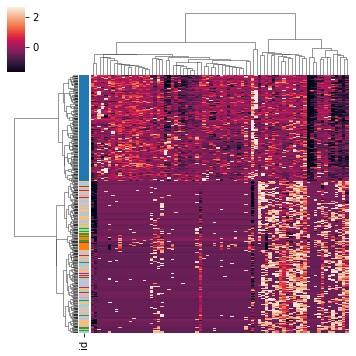

In [386]:
sns.clustermap(merged_df, method = 'ward', xticklabels = False, yticklabels = False, robust = True, row_colors = row_colors, figsize=(5,5), z_score=0)

#### SC data
Note that single cell count matrix is the "counts" slot from Seurat v4 `seurat.object@assays$RNA@data`

In [387]:
sc_data = pd.read_table("/Users/heustonef/Desktop/10XGenomicsData/MergeBiomarkWith10X/MEPSubpop_vBiomark_Data-BiomarkProbes.txt", sep="\t", index_col=0)
sc_data = sc_data.rename({"RNA_snn_res.0.5":"id"}, axis='columns')
sc_data.head(n = 2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123,id
Row.names,,,,,,,,,,,,,,,,,,,,,
MEPm_AAACTTGAGAATAG-1,0.0,6.956910,0,3.461483,7.362058,6.139805,0,7.895877,0,0,...,0.0,4.538951,4.138814,3.461483,6.070966,5.380125,0.000000,0.0,0.0,1
MEPm_AAAGAGACGGAAGC-1,0.0,6.248878,0,0.000000,6.740603,0.000000,0,5.931149,0,0,...,0.0,8.231341,3.870125,0.000000,0.000000,4.552789,3.870125,0.0,0.0,6


In [388]:
sc_data.shape

(251, 93)

In [389]:
sclog_data = sc_data.copy().drop(['Shisa5', 'Eef2', 'H2-Ab1', 'id'], axis = 1)
sclog_data = np.log2(1/sclog_data)
transform_factor = 5-sclog_data.min().min()
sclog_data = sclog_data + transform_factor
sclog_data[np.isinf(sclog_data)] = np.nan
sclog_data.head(2)

,AA467197,Actb,Aif1,Apoe,B2m,Birc5,Camp,Car2,Ccl3,Ccl9,...,Tfrc,Tmod1,Tmsb4x,Tsc22d1,Txnip,Ube2c,Vamp5,Vwf,Cd117,Cd123
Row.names,,,,,,,,,,,,,,,,,,,,,
MEPm_AAACTTGAGAATAG-1,NaN,5.262375,NaN,6.269431,5.180713,5.442629,NaN,5.079722,NaN,NaN,...,6.269431,NaN,5.878463,6.011604,6.269431,5.458896,5.633182,NaN,NaN,NaN
MEPm_AAAGAGACGGAAGC-1,NaN,5.417224,NaN,NaN,5.307944,NaN,NaN,5.492510,NaN,NaN,...,NaN,NaN,5.019694,6.108442,NaN,NaN,5.874071,6.108442,NaN,NaN


##### dCt

In [390]:
dsclog_data = dCt(sclog_data)
# dsclog_data = 2**-dsclog_data
dsclog_data = dsclog_data.fillna(0)

In [391]:
dbiomark['id'] = 'biomark'
dsclog_data['id'] = 'sc'

In [392]:
pd.concat([dbiomark.describe().mean(axis = 1), dsclog_data.describe().mean(axis = 1)], axis = 1)

,0,1
count,176.000000,251.000000
mean,0.601661,0.097157
std,2.888035,0.160344
min,-5.201660,-0.089091
25%,-0.769719,-0.004985
50%,-0.108410,0.049564
75%,1.307003,0.160474
max,15.242443,0.765649


In [393]:
merged_df = pd.concat([dbiomark, dsclog_data], join = 'inner', axis = 0)

cell_id = merged_df.pop("id")
merged_df = merged_df.fillna(0)

lut = dict(zip(cell_id.unique(), sns.color_palette('tab20')))
row_colors = cell_id.map(lut)

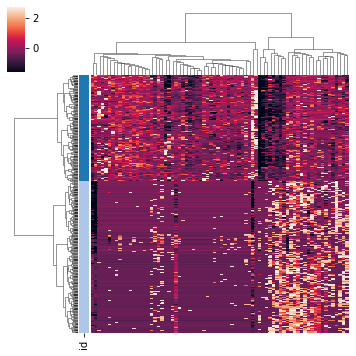

In [394]:
sns.clustermap(merged_df, method = 'ward', xticklabels = False, yticklabels = False, robust = True, row_colors = row_colors, figsize=(5,5), z_score=0)

## Merging

### Sklearn Scaling

In [43]:
from sklearn.preprocessing import RobustScaler
robustscaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25, 75))

In [44]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(1, 10))

In [50]:
ref_list = ['Actb', 'B2m', 'Cd117']

#### RobustScaler - dsclog_cts

In [395]:
dscrobust_cts =  pd.DataFrame(robustscaler.fit_transform(dsclog_cts.drop('id', axis = 1)), index = dsclog_cts.index, columns=dsclog_cts.columns[:-1]).fillna(0)
dscrobust_cts['id'] = sc_cts['id']
dscrobust_cts['tech'] = 'sc'
dbiomarkrobust = pd.DataFrame(robustscaler.fit_transform(dbiomark.drop('id', axis = 1)), index = dbiomark.index, columns=dbiomark.columns[:-1]).fillna(0)
dbiomarkrobust['id'] = 'biomark'
dbiomarkrobust['tech'] = 'biomark'

In [396]:
pd.concat([round(dscrobust_cts.describe().mean(axis = 1), 3), round(dbiomarkrobust.describe().mean(axis = 1), 3)], axis = 1)

,0,1
count,251.000,176.000
mean,0.161,0.487
std,0.554,2.139
min,-0.398,-4.228
25%,-0.133,-0.252
50%,0.011,0.000
75%,0.267,0.555
max,2.802,14.307


In [397]:
pd.concat([dscrobust_cts[ref_list].describe().mean(axis = 1), dbiomarkrobust[ref_list].describe().mean(axis = 1)], axis=1)

,0,1
count,251.000000,176.000000
mean,0.081521,0.103816
std,0.550381,0.739978
min,-0.855305,-1.884145
25%,-0.426587,-0.408219
50%,0.000000,0.000000
75%,0.573413,0.591781
max,1.384653,2.539814


In [398]:
pal = ['#000000'] + sns.color_palette('tab10').as_hex()

dmerged_robust = pd.concat([dbiomarkrobust, dscrobust_cts], join = 'inner', axis = 0)

cell_id = dmerged_robust.pop("id")
tech_id = dmerged_robust.pop('tech')
dmerged_robust = dmerged_robust.fillna(0)

lut_cell = dict(zip(cell_id.unique(), pal))
row_colors_cell = cell_id.map(lut_cell)

lut_tech = dict(zip(tech_id.unique(), ['#000000', '#FFFFFF']))
row_colors_tech = tech_id.map(lut_tech)

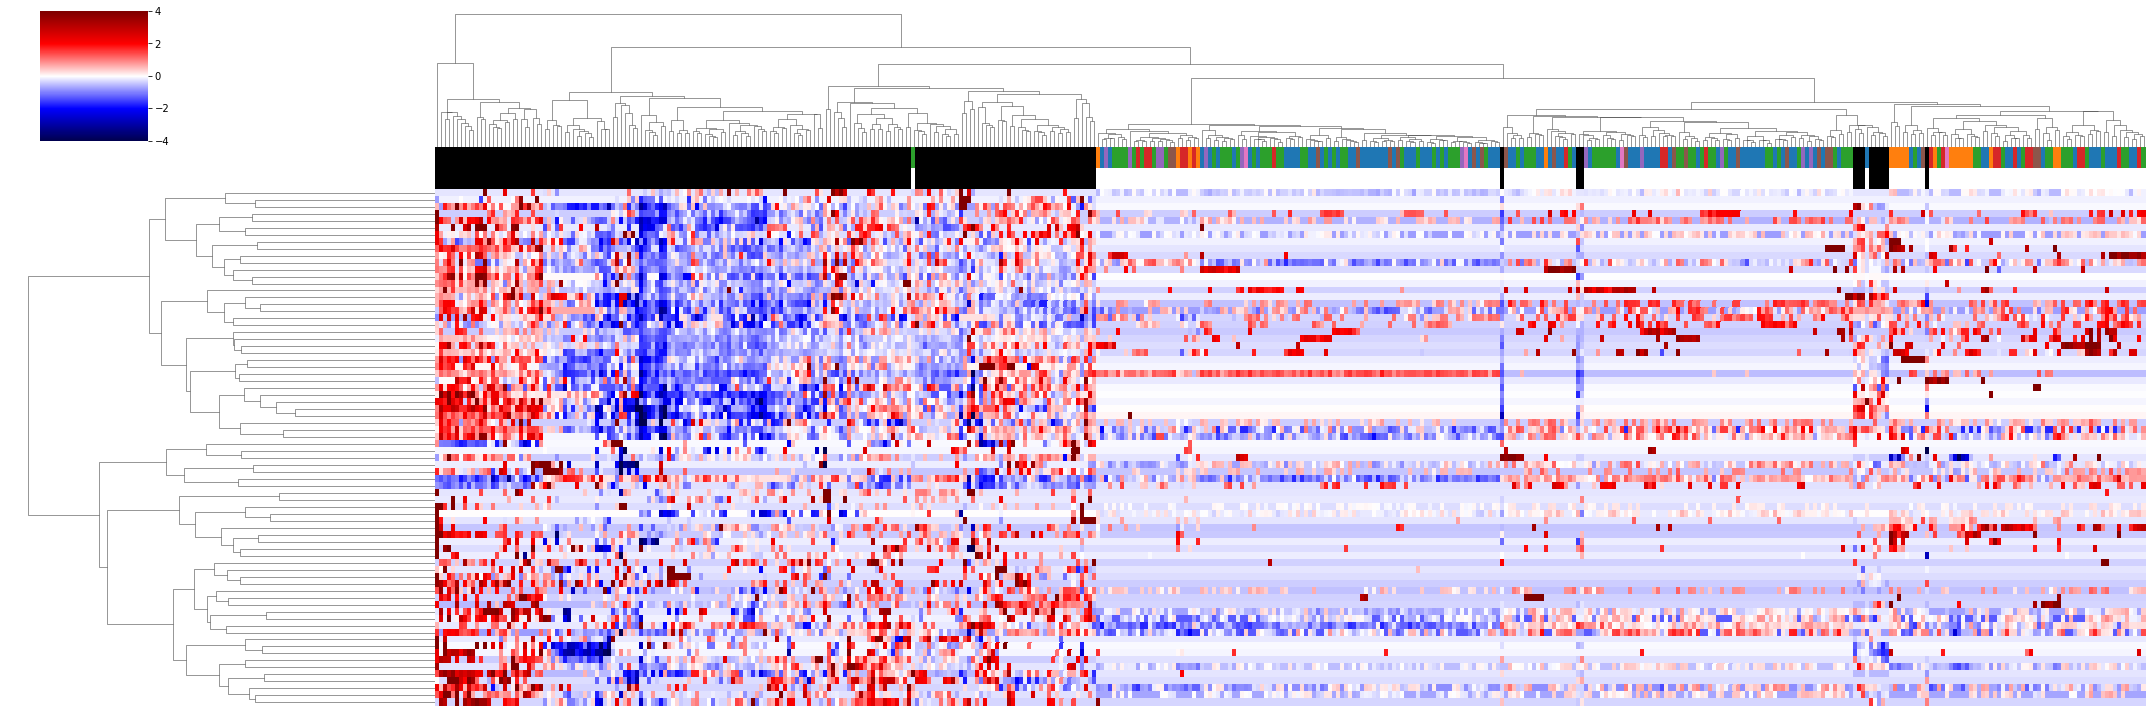

In [399]:
sns.clustermap(dmerged_robust.transpose(), method = 'ward', xticklabels = False, yticklabels = False, col_colors = [row_colors_cell, row_colors_tech], figsize=(30, 10), center = 0, cmap = "seismic", vmin = -4, vmax = 4, z_score=0)

#### RobustScaler - dsclog_data

In [400]:
dscrobust_data =  pd.DataFrame(robustscaler.fit_transform(dsclog_data.drop('id', axis = 1)), index = dsclog_data.index, columns=dsclog_data.columns[:-1]).fillna(0)
dscrobust_data['id'] = sc_data['id']
dscrobust_data['tech'] = 'sc'

dbiomarkrobust = pd.DataFrame(robustscaler.fit_transform(dbiomark.drop('id', axis = 1)), index = dbiomark.index, columns=dbiomark.columns[:-1]).fillna(0)
dbiomarkrobust['id'] = 'biomark'
dbiomarkrobust['tech'] = 'biomark'

In [401]:
pd.concat([round(dscrobust_data.describe().mean(axis = 1), 3), round(dbiomarkrobust.describe().mean(axis = 1), 3)], axis = 1)

,0,1
count,251.000,176.000
mean,0.100,0.487
std,0.316,2.139
min,-0.320,-4.228
25%,-0.130,-0.252
50%,0.011,0.000
75%,0.270,0.555
max,1.178,14.307


In [402]:
pd.concat([dscrobust_data[ref_list].describe().mean(axis = 1), dbiomarkrobust[ref_list].describe().mean(axis = 1)], axis=1)

,0,1
count,251.000000,176.000000
mean,0.043544,0.103816
std,0.549986,0.739978
min,-0.884469,-1.884145
25%,-0.464329,-0.408219
50%,0.000000,0.000000
75%,0.535671,0.591781
max,1.268125,2.539814


In [403]:
pal = ['#000000'] + sns.color_palette('tab10').as_hex()

dmergedrobust_data = pd.concat([dbiomarkrobust, dscrobust_data], join = 'inner', axis = 0)

cell_id = dmergedrobust_data.pop("id")
dmergedrobust_data = dmergedrobust_data.fillna(0)
lut_cell = dict(zip(cell_id.unique(), pal))
row_colors_cell = cell_id.map(lut_cell)

cell_id = dmergedrobust_data.pop("tech")
dmergedrobust_data = dmergedrobust_data.fillna(0)
lut = dict(zip(cell_id.unique(), ['#000000', '#FFFFFF']))
row_colors_tech = cell_id.map(lut_tech)

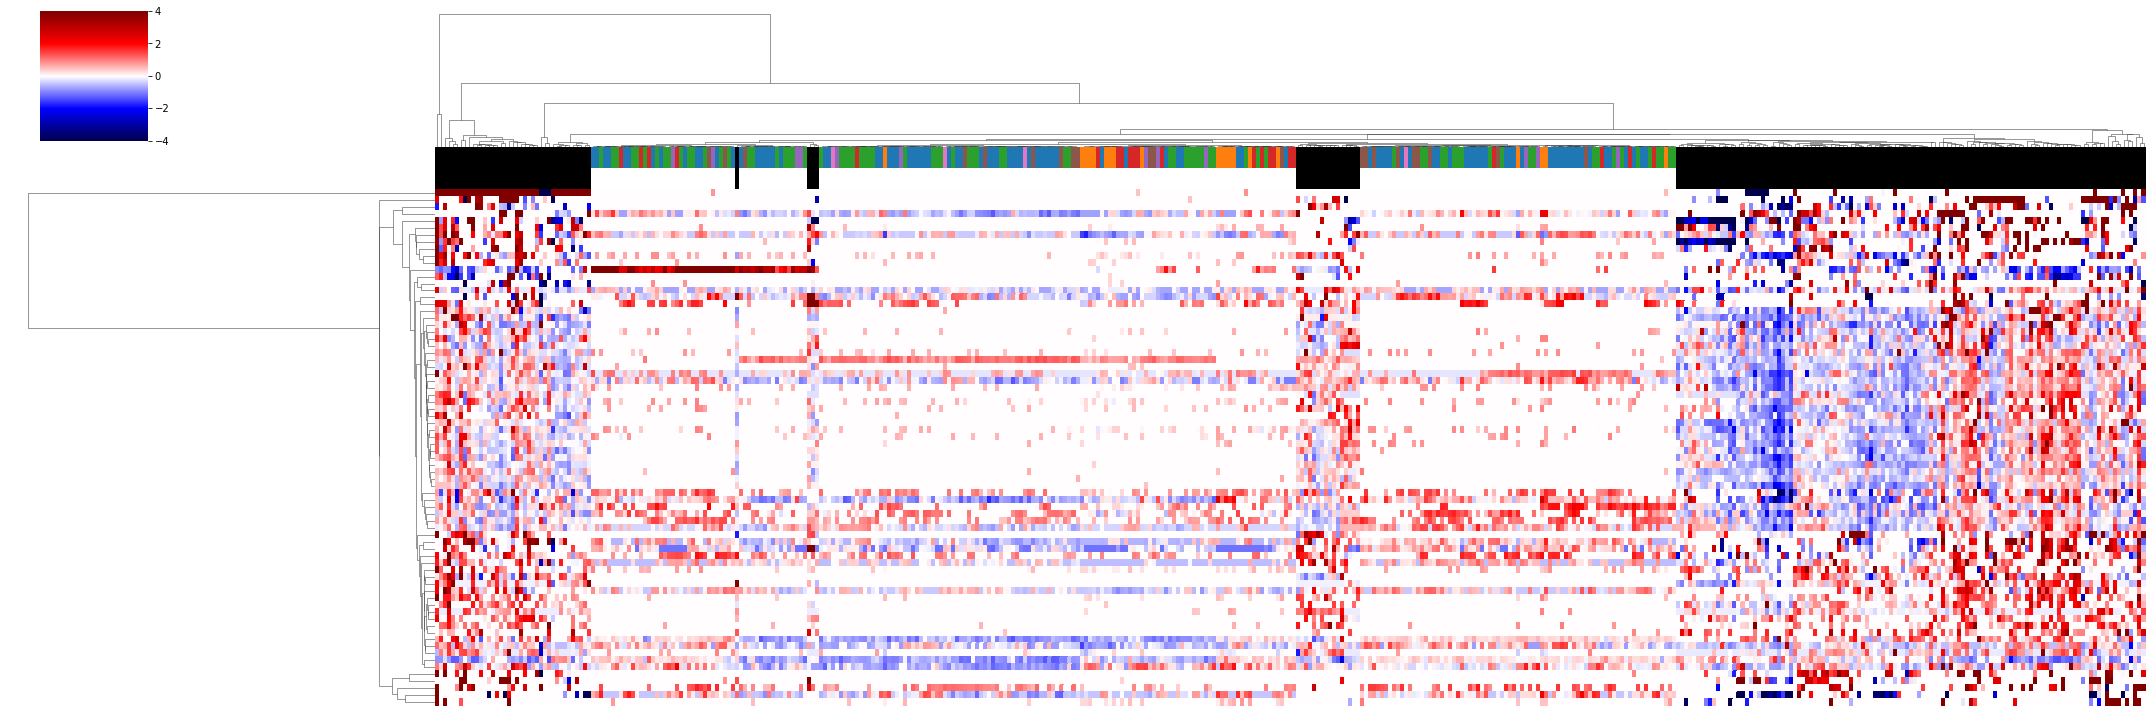

In [404]:
sns.clustermap(dmergedrobust_data.transpose(), method = 'ward', xticklabels = False, yticklabels = False, col_colors = [row_colors_cell, row_colors_tech], figsize=(30, 10), center = 0, cmap = "seismic", vmin = -4, vmax = 4)

# Normalization Notes

[Bioconductor Support Article](https://support.bioconductor.org/p/34182/)

Other approaches

[Published data analysis for 96.96 Dynamic Array IFC](https://www.gene-quantification.de/livak-methods-59-transcriptional-biomarkers-2013.pdf)  
* Data analyzed using Fluidigm Real-Time PCR Analysis software  
    * Used linear (derivative) baseline correction method  
    * Used Auto (global) Ct threshold method (alt. 0.01)
    * Ct range 12 - 28 cycles
    * Export Cq values  

[G. Guo, Dev. Cell; 18 (2010) 675–685.](https://www.sciencedirect.com/science/article/pii/S1534580710001103#sec4)
* Relative expression determined by subtracting Ct value from "assumed baseline of 28"
* Remove cells with absent/low endogenous controls (~10%)
* Normalize these by subtracting average of ActB+GAPDH expression levels

[geNorm method](https://doi.org/10.1186/gb-2002-3-7-research0034)
* Average control genes using __geometric mean__ (not arithmatic mean)
    * genorm support stops with python 2.7 
    * R may have an implementation for it via [NormqPCR](https://www.bioconductor.org/packages/release/bioc/html/NormqPCR.html)
    
[ERgene](https://www.nature.com/articles/s41598-020-75586-5)
* Python library to for gene nomralization [github](https://github.com/Starlitnightly/ERgene)

[Beth Psaila's Approach](https://doi.org/10.1186/s13059-016-0939-7)
* Exclude assays with:
    * LOD (limit of detection) >= 40
* Exclude cells with:
    * >70 failed assays
    * B2M >= 13
    * GAPDH >= 15
    * Cells with mean Ct > 20
* Norm to average of [B2M & GAPDH]
* Expression = 2^-(NormCt)
* Exclude HKgenes

Going with Beth's method because it's the most thoroughly described.
Might also gofor quantile nomrlization